In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from pathlib import Path
import pandas as pd
import numpy as np

from utils import (cross_validate_hyperparameters, train_model, test_model,
                   show_random_images, plot_class_distribution,)
from cnn_model import BasicCNN, DeepCNN, ResNet, EnsembleModel

if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

Path("../model").mkdir(parents=True, exist_ok=True)
Path("../result").mkdir(parents=True, exist_ok=True)

Using device: cuda


In [2]:
# 超参数
batch_size = 256
num_epochs = 100

In [3]:
# 数据增强和预处理
transforms_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transforms_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 加载CIFAR-10数据集
train_dataset = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=True, transform=transforms_train)
test_dataset = torchvision.datasets.CIFAR10(
    root='../data', train=False, download=True, transform=transforms_test)

# 分离出验证集
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# 数据加载器
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# CIFAR-10 类别
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


显示训练集样本:


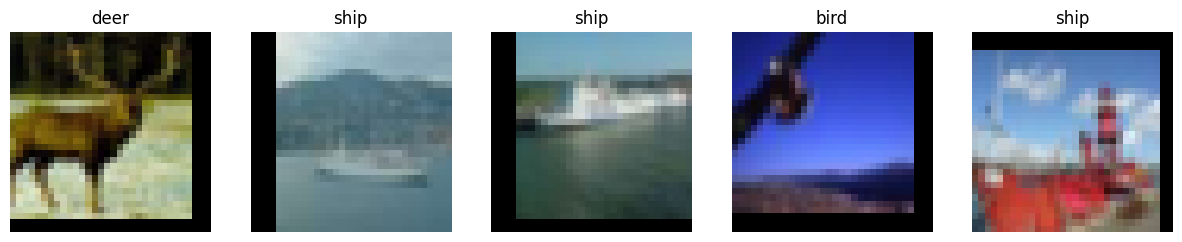

训练集类别分布:


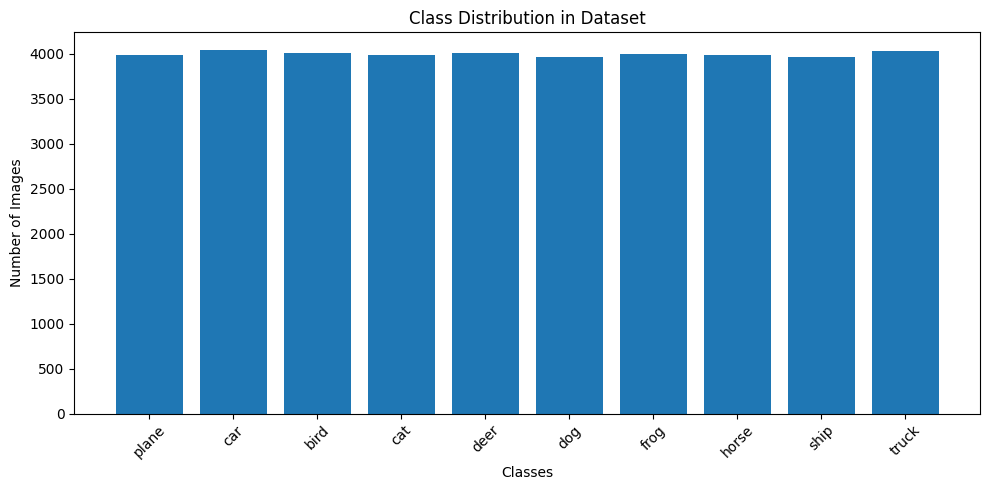

In [4]:
# 显示一些随机样本
print("显示训练集样本:")
show_random_images(train_dataset, classes)

# 显示类别分布
print("训练集类别分布:")
plot_class_distribution(train_dataset, classes)

In [5]:
# 交叉验证寻找最佳超参数
print("\n===== 开始交叉验证 =====")
cv_params = {
    'dropout_rate': [0.2, 0.5],
    'normalization': ['batch', 'instance', 'layer', 'group', 'none'],
    'num_filters_1': [32],
    'num_filters_2': [64]
}

# 使用小型数据集进行交叉验证以节省时间
cv_subset = torch.utils.data.Subset(
    train_dataset,
    indices=np.random.choice(len(train_dataset), size=int(len(train_dataset) * 0.2), replace=False)
)

best_params = cross_validate_hyperparameters(
    BasicCNN,
    cv_params,
    cv_subset,
    num_folds=3,
    batch_size=64,
    num_epochs=3,
    device=device
)


===== 开始交叉验证 =====
Testing hyperparameters: {'dropout_rate': 0.2, 'normalization': 'batch', 'num_filters_1': 32, 'num_filters_2': 64}
  Fold 1/3


Epoch 1/3: 100%|██████████| 84/84 [00:04<00:00, 20.91it/s]


    Epoch 1: Validation Accuracy = 37.27%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 43.95it/s]


    Epoch 2: Validation Accuracy = 41.51%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 43.99it/s]


    Epoch 3: Validation Accuracy = 42.71%
  Fold 2/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 44.59it/s]


    Epoch 1: Validation Accuracy = 33.60%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 43.95it/s]


    Epoch 2: Validation Accuracy = 39.26%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 43.52it/s]


    Epoch 3: Validation Accuracy = 43.42%
  Fold 3/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 43.42it/s]


    Epoch 1: Validation Accuracy = 31.28%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 43.83it/s]


    Epoch 2: Validation Accuracy = 37.73%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 43.13it/s]


    Epoch 3: Validation Accuracy = 40.29%
  Average validation accuracy: 42.14%
Testing hyperparameters: {'dropout_rate': 0.2, 'normalization': 'instance', 'num_filters_1': 32, 'num_filters_2': 64}
  Fold 1/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 44.17it/s]


    Epoch 1: Validation Accuracy = 30.71%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 44.51it/s]


    Epoch 2: Validation Accuracy = 36.78%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 44.49it/s]


    Epoch 3: Validation Accuracy = 40.72%
  Fold 2/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 44.68it/s]


    Epoch 1: Validation Accuracy = 32.51%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 44.90it/s]


    Epoch 2: Validation Accuracy = 35.25%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 43.77it/s]


    Epoch 3: Validation Accuracy = 41.24%
  Fold 3/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 45.00it/s]


    Epoch 1: Validation Accuracy = 31.25%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 44.80it/s]


    Epoch 2: Validation Accuracy = 38.00%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 44.36it/s]


    Epoch 3: Validation Accuracy = 41.07%
  Average validation accuracy: 41.01%
Testing hyperparameters: {'dropout_rate': 0.2, 'normalization': 'layer', 'num_filters_1': 32, 'num_filters_2': 64}
  Fold 1/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 44.72it/s]


    Epoch 1: Validation Accuracy = 31.87%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 44.93it/s]


    Epoch 2: Validation Accuracy = 38.32%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 44.31it/s]


    Epoch 3: Validation Accuracy = 41.77%
  Fold 2/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 43.76it/s]


    Epoch 1: Validation Accuracy = 28.35%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 44.94it/s]


    Epoch 2: Validation Accuracy = 36.63%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 44.25it/s]


    Epoch 3: Validation Accuracy = 37.16%
  Fold 3/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 43.56it/s]


    Epoch 1: Validation Accuracy = 26.97%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 43.48it/s]


    Epoch 2: Validation Accuracy = 35.56%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 44.83it/s]


    Epoch 3: Validation Accuracy = 39.46%
  Average validation accuracy: 39.46%
Testing hyperparameters: {'dropout_rate': 0.2, 'normalization': 'group', 'num_filters_1': 32, 'num_filters_2': 64}
  Fold 1/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 43.46it/s]


    Epoch 1: Validation Accuracy = 32.32%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 43.84it/s]


    Epoch 2: Validation Accuracy = 35.85%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 43.56it/s]


    Epoch 3: Validation Accuracy = 37.38%
  Fold 2/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 44.87it/s]


    Epoch 1: Validation Accuracy = 32.10%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 45.16it/s]


    Epoch 2: Validation Accuracy = 40.04%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 45.01it/s]


    Epoch 3: Validation Accuracy = 40.23%
  Fold 3/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 43.80it/s]


    Epoch 1: Validation Accuracy = 33.46%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 43.99it/s]


    Epoch 2: Validation Accuracy = 36.80%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 44.32it/s]


    Epoch 3: Validation Accuracy = 39.83%
  Average validation accuracy: 39.15%
Testing hyperparameters: {'dropout_rate': 0.2, 'normalization': 'none', 'num_filters_1': 32, 'num_filters_2': 64}
  Fold 1/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 44.56it/s]


    Epoch 1: Validation Accuracy = 31.42%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 44.64it/s]


    Epoch 2: Validation Accuracy = 37.35%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 44.67it/s]


    Epoch 3: Validation Accuracy = 40.64%
  Fold 2/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 45.79it/s]


    Epoch 1: Validation Accuracy = 32.85%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 45.74it/s]


    Epoch 2: Validation Accuracy = 38.81%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 46.04it/s]


    Epoch 3: Validation Accuracy = 43.16%
  Fold 3/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 45.69it/s]


    Epoch 1: Validation Accuracy = 32.78%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 45.18it/s]


    Epoch 2: Validation Accuracy = 39.42%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 45.29it/s]


    Epoch 3: Validation Accuracy = 41.04%
  Average validation accuracy: 41.61%
Testing hyperparameters: {'dropout_rate': 0.5, 'normalization': 'batch', 'num_filters_1': 32, 'num_filters_2': 64}
  Fold 1/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 44.15it/s]


    Epoch 1: Validation Accuracy = 27.45%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 44.76it/s]


    Epoch 2: Validation Accuracy = 34.57%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 44.74it/s]


    Epoch 3: Validation Accuracy = 40.94%
  Fold 2/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 44.95it/s]


    Epoch 1: Validation Accuracy = 29.06%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 44.63it/s]


    Epoch 2: Validation Accuracy = 30.56%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 44.58it/s]


    Epoch 3: Validation Accuracy = 34.83%
  Fold 3/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 44.27it/s]


    Epoch 1: Validation Accuracy = 32.90%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 44.02it/s]


    Epoch 2: Validation Accuracy = 34.96%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 43.98it/s]


    Epoch 3: Validation Accuracy = 36.87%
  Average validation accuracy: 37.55%
Testing hyperparameters: {'dropout_rate': 0.5, 'normalization': 'instance', 'num_filters_1': 32, 'num_filters_2': 64}
  Fold 1/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 43.32it/s]


    Epoch 1: Validation Accuracy = 19.76%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 43.67it/s]


    Epoch 2: Validation Accuracy = 23.55%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 44.55it/s]


    Epoch 3: Validation Accuracy = 29.66%
  Fold 2/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 45.69it/s]


    Epoch 1: Validation Accuracy = 22.95%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 45.64it/s]


    Epoch 2: Validation Accuracy = 21.56%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 45.88it/s]


    Epoch 3: Validation Accuracy = 26.28%
  Fold 3/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 45.17it/s]


    Epoch 1: Validation Accuracy = 20.86%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 45.53it/s]


    Epoch 2: Validation Accuracy = 25.54%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 45.07it/s]


    Epoch 3: Validation Accuracy = 21.91%
  Average validation accuracy: 27.16%
Testing hyperparameters: {'dropout_rate': 0.5, 'normalization': 'layer', 'num_filters_1': 32, 'num_filters_2': 64}
  Fold 1/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 45.20it/s]


    Epoch 1: Validation Accuracy = 26.85%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 43.68it/s]


    Epoch 2: Validation Accuracy = 31.08%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 44.21it/s]


    Epoch 3: Validation Accuracy = 34.65%
  Fold 2/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 44.49it/s]


    Epoch 1: Validation Accuracy = 25.50%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 44.75it/s]


    Epoch 2: Validation Accuracy = 29.02%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 45.20it/s]


    Epoch 3: Validation Accuracy = 32.96%
  Fold 3/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 45.17it/s]


    Epoch 1: Validation Accuracy = 24.23%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 45.22it/s]


    Epoch 2: Validation Accuracy = 32.22%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 44.95it/s]


    Epoch 3: Validation Accuracy = 30.98%
  Average validation accuracy: 33.27%
Testing hyperparameters: {'dropout_rate': 0.5, 'normalization': 'group', 'num_filters_1': 32, 'num_filters_2': 64}
  Fold 1/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 45.14it/s]


    Epoch 1: Validation Accuracy = 25.65%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 44.53it/s]


    Epoch 2: Validation Accuracy = 33.56%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 44.63it/s]


    Epoch 3: Validation Accuracy = 34.35%
  Fold 2/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 44.76it/s]


    Epoch 1: Validation Accuracy = 22.27%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 44.80it/s]


    Epoch 2: Validation Accuracy = 26.28%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 44.89it/s]


    Epoch 3: Validation Accuracy = 26.73%
  Fold 3/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 43.53it/s]


    Epoch 1: Validation Accuracy = 25.02%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 43.76it/s]


    Epoch 2: Validation Accuracy = 29.67%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 44.80it/s]


    Epoch 3: Validation Accuracy = 31.81%
  Average validation accuracy: 30.96%
Testing hyperparameters: {'dropout_rate': 0.5, 'normalization': 'none', 'num_filters_1': 32, 'num_filters_2': 64}
  Fold 1/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 46.46it/s]


    Epoch 1: Validation Accuracy = 30.82%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 46.44it/s]


    Epoch 2: Validation Accuracy = 36.75%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 46.53it/s]


    Epoch 3: Validation Accuracy = 40.94%
  Fold 2/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 46.43it/s]


    Epoch 1: Validation Accuracy = 31.65%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 46.67it/s]


    Epoch 2: Validation Accuracy = 38.21%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 46.22it/s]


    Epoch 3: Validation Accuracy = 41.88%
  Fold 3/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 46.91it/s]


    Epoch 1: Validation Accuracy = 31.25%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 46.02it/s]


    Epoch 2: Validation Accuracy = 36.08%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 46.21it/s]


    Epoch 3: Validation Accuracy = 39.23%
  Average validation accuracy: 40.69%

===== Cross-Validation Results =====
Parameters: {'dropout_rate': 0.2, 'normalization': 'batch', 'num_filters_1': 32, 'num_filters_2': 64}
  Average accuracy: 42.14%
  Fold accuracies: [42.7071616047994, 43.41957255343082, 40.28507126781695]
Parameters: {'dropout_rate': 0.2, 'normalization': 'none', 'num_filters_1': 32, 'num_filters_2': 64}
  Average accuracy: 41.61%
  Fold accuracies: [40.64491938507687, 43.15710536182977, 41.035258814703674]
Parameters: {'dropout_rate': 0.2, 'normalization': 'instance', 'num_filters_1': 32, 'num_filters_2': 64}
  Average accuracy: 41.01%
  Fold accuracies: [40.719910011248594, 41.244844394450695, 41.07276819204801]
Parameters: {'dropout_rate': 0.5, 'normalization': 'none', 'num_filters_1': 32, 'num_filters_2': 64}
  Average accuracy: 40.69%
  Fold accuracies: [40.94488188976378, 41.882264716910385, 39.23480870217554]
Parameters: {'dropout_rate': 0.2, 'normalization': 'la

In [6]:
# 使用最佳参数训练模型
print("\n===== 使用最佳参数训练模型 =====")
model_cnn = BasicCNN(**best_params).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

history_cnn = train_model(
    model_cnn,
    train_loader,
    val_loader,
    test_loader,
    criterion,
    optimizer,
    num_epochs,
    device,
    'BasicCNN_BestParams',
    scheduler
)


===== 使用最佳参数训练模型 =====


Epoch 1/100: 100%|██████████| 157/157 [00:06<00:00, 22.50it/s, loss: 1.6572 - acc: 39.46%]


Epoch 1/100 - loss: 1.6572 - acc: 39.46% - val_loss: 1.3636 - val_acc: 49.81% - test_acc: 51.89%


Epoch 2/100: 100%|██████████| 157/157 [00:06<00:00, 23.52it/s, loss: 1.3509 - acc: 50.95%]


Epoch 2/100 - loss: 1.3509 - acc: 50.95% - val_loss: 1.2508 - val_acc: 54.30% - test_acc: 58.35%


Epoch 3/100: 100%|██████████| 157/157 [00:06<00:00, 24.05it/s, loss: 1.2541 - acc: 54.73%]


Epoch 3/100 - loss: 1.2541 - acc: 54.73% - val_loss: 1.1694 - val_acc: 57.82% - test_acc: 61.90%


Epoch 4/100: 100%|██████████| 157/157 [00:06<00:00, 23.64it/s, loss: 1.1808 - acc: 57.62%]


Epoch 4/100 - loss: 1.1808 - acc: 57.62% - val_loss: 1.1113 - val_acc: 60.33% - test_acc: 64.38%


Epoch 5/100: 100%|██████████| 157/157 [00:06<00:00, 24.18it/s, loss: 1.1348 - acc: 59.75%]


Epoch 5/100 - loss: 1.1348 - acc: 59.75% - val_loss: 1.0713 - val_acc: 60.95% - test_acc: 65.20%


Epoch 6/100: 100%|██████████| 157/157 [00:06<00:00, 24.28it/s, loss: 1.1029 - acc: 60.59%]


Epoch 6/100 - loss: 1.1029 - acc: 60.59% - val_loss: 1.0283 - val_acc: 63.12% - test_acc: 66.98%


Epoch 7/100: 100%|██████████| 157/157 [00:06<00:00, 24.36it/s, loss: 1.0696 - acc: 61.98%]


Epoch 7/100 - loss: 1.0696 - acc: 61.98% - val_loss: 1.0330 - val_acc: 62.51% - test_acc: 66.23%


Epoch 8/100: 100%|██████████| 157/157 [00:06<00:00, 24.19it/s, loss: 1.0493 - acc: 62.55%]


Epoch 8/100 - loss: 1.0493 - acc: 62.55% - val_loss: 0.9851 - val_acc: 65.04% - test_acc: 68.43%


Epoch 9/100: 100%|██████████| 157/157 [00:06<00:00, 24.29it/s, loss: 1.0338 - acc: 63.28%]


Epoch 9/100 - loss: 1.0338 - acc: 63.28% - val_loss: 0.9415 - val_acc: 66.57% - test_acc: 70.30%


Epoch 10/100: 100%|██████████| 157/157 [00:06<00:00, 24.26it/s, loss: 1.0029 - acc: 64.31%]


Epoch 10/100 - loss: 1.0029 - acc: 64.31% - val_loss: 0.9973 - val_acc: 64.36% - test_acc: 68.12%


Epoch 11/100: 100%|██████████| 157/157 [00:06<00:00, 24.34it/s, loss: 0.9890 - acc: 64.67%]


Epoch 11/100 - loss: 0.9890 - acc: 64.67% - val_loss: 0.9248 - val_acc: 67.10% - test_acc: 70.79%


Epoch 12/100: 100%|██████████| 157/157 [00:06<00:00, 24.25it/s, loss: 0.9769 - acc: 65.21%]


Epoch 12/100 - loss: 0.9769 - acc: 65.21% - val_loss: 0.9313 - val_acc: 67.35% - test_acc: 70.47%


Epoch 13/100: 100%|██████████| 157/157 [00:06<00:00, 24.16it/s, loss: 0.9709 - acc: 65.46%]


Epoch 13/100 - loss: 0.9709 - acc: 65.46% - val_loss: 0.9092 - val_acc: 68.01% - test_acc: 71.10%


Epoch 14/100: 100%|██████████| 157/157 [00:06<00:00, 24.22it/s, loss: 0.9436 - acc: 66.64%]


Epoch 14/100 - loss: 0.9436 - acc: 66.64% - val_loss: 0.8763 - val_acc: 68.47% - test_acc: 72.75%


Epoch 15/100: 100%|██████████| 157/157 [00:06<00:00, 24.12it/s, loss: 0.9455 - acc: 66.58%]


Epoch 15/100 - loss: 0.9455 - acc: 66.58% - val_loss: 0.9206 - val_acc: 67.67% - test_acc: 71.48%


Epoch 16/100: 100%|██████████| 157/157 [00:06<00:00, 24.22it/s, loss: 0.9251 - acc: 67.25%]


Epoch 16/100 - loss: 0.9251 - acc: 67.25% - val_loss: 0.9681 - val_acc: 65.66% - test_acc: 70.06%


Epoch 17/100: 100%|██████████| 157/157 [00:06<00:00, 24.24it/s, loss: 0.9178 - acc: 67.42%]


Epoch 17/100 - loss: 0.9178 - acc: 67.42% - val_loss: 0.9117 - val_acc: 67.37% - test_acc: 70.25%


Epoch 18/100: 100%|██████████| 157/157 [00:06<00:00, 24.29it/s, loss: 0.9073 - acc: 68.13%]


Epoch 18/100 - loss: 0.9073 - acc: 68.13% - val_loss: 0.8782 - val_acc: 68.07% - test_acc: 72.08%


Epoch 19/100: 100%|██████████| 157/157 [00:06<00:00, 24.19it/s, loss: 0.8934 - acc: 68.56%]


Epoch 19/100 - loss: 0.8934 - acc: 68.56% - val_loss: 0.8589 - val_acc: 69.45% - test_acc: 72.36%


Epoch 20/100: 100%|██████████| 157/157 [00:06<00:00, 24.04it/s, loss: 0.8850 - acc: 68.97%]


Epoch 20/100 - loss: 0.8850 - acc: 68.97% - val_loss: 0.8644 - val_acc: 69.71% - test_acc: 72.39%


Epoch 21/100: 100%|██████████| 157/157 [00:06<00:00, 24.14it/s, loss: 0.8723 - acc: 69.39%]


Epoch 21/100 - loss: 0.8723 - acc: 69.39% - val_loss: 0.8532 - val_acc: 69.86% - test_acc: 73.60%


Epoch 22/100: 100%|██████████| 157/157 [00:06<00:00, 23.94it/s, loss: 0.8735 - acc: 69.04%]


Epoch 22/100 - loss: 0.8735 - acc: 69.04% - val_loss: 0.8473 - val_acc: 70.07% - test_acc: 73.44%


Epoch 23/100: 100%|██████████| 157/157 [00:06<00:00, 23.98it/s, loss: 0.8702 - acc: 69.29%]


Epoch 23/100 - loss: 0.8702 - acc: 69.29% - val_loss: 0.8369 - val_acc: 70.58% - test_acc: 73.65%


Epoch 24/100: 100%|██████████| 157/157 [00:06<00:00, 23.86it/s, loss: 0.8611 - acc: 69.78%]


Epoch 24/100 - loss: 0.8611 - acc: 69.78% - val_loss: 0.8096 - val_acc: 70.82% - test_acc: 74.66%


Epoch 25/100: 100%|██████████| 157/157 [00:06<00:00, 23.85it/s, loss: 0.8503 - acc: 69.86%]


Epoch 25/100 - loss: 0.8503 - acc: 69.86% - val_loss: 0.8194 - val_acc: 70.91% - test_acc: 73.48%


Epoch 26/100: 100%|██████████| 157/157 [00:06<00:00, 23.73it/s, loss: 0.8415 - acc: 70.20%]


Epoch 26/100 - loss: 0.8415 - acc: 70.20% - val_loss: 0.7975 - val_acc: 71.86% - test_acc: 75.35%


Epoch 27/100: 100%|██████████| 157/157 [00:06<00:00, 23.94it/s, loss: 0.8366 - acc: 70.59%]


Epoch 27/100 - loss: 0.8366 - acc: 70.59% - val_loss: 0.8233 - val_acc: 70.48% - test_acc: 74.34%


Epoch 28/100: 100%|██████████| 157/157 [00:06<00:00, 23.73it/s, loss: 0.8280 - acc: 70.85%]


Epoch 28/100 - loss: 0.8280 - acc: 70.85% - val_loss: 0.8360 - val_acc: 70.78% - test_acc: 74.09%


Epoch 29/100: 100%|██████████| 157/157 [00:06<00:00, 23.84it/s, loss: 0.8319 - acc: 70.78%]


Epoch 29/100 - loss: 0.8319 - acc: 70.78% - val_loss: 0.8013 - val_acc: 71.81% - test_acc: 74.98%


Epoch 30/100: 100%|██████████| 157/157 [00:06<00:00, 24.01it/s, loss: 0.8240 - acc: 71.19%]


Epoch 30/100 - loss: 0.8240 - acc: 71.19% - val_loss: 0.7828 - val_acc: 72.29% - test_acc: 75.28%


Epoch 31/100: 100%|██████████| 157/157 [00:06<00:00, 23.74it/s, loss: 0.8181 - acc: 71.34%]


Epoch 31/100 - loss: 0.8181 - acc: 71.34% - val_loss: 0.8352 - val_acc: 70.84% - test_acc: 73.99%


Epoch 32/100: 100%|██████████| 157/157 [00:06<00:00, 23.65it/s, loss: 0.8187 - acc: 71.16%]


Epoch 32/100 - loss: 0.8187 - acc: 71.16% - val_loss: 0.8304 - val_acc: 70.68% - test_acc: 73.82%


Epoch 33/100: 100%|██████████| 157/157 [00:06<00:00, 24.11it/s, loss: 0.8154 - acc: 71.23%]


Epoch 33/100 - loss: 0.8154 - acc: 71.23% - val_loss: 0.7601 - val_acc: 72.74% - test_acc: 75.86%


Epoch 34/100: 100%|██████████| 157/157 [00:06<00:00, 24.14it/s, loss: 0.8050 - acc: 71.55%]


Epoch 34/100 - loss: 0.8050 - acc: 71.55% - val_loss: 0.8289 - val_acc: 70.67% - test_acc: 73.60%


Epoch 35/100: 100%|██████████| 157/157 [00:06<00:00, 23.92it/s, loss: 0.7944 - acc: 72.03%]


Epoch 35/100 - loss: 0.7944 - acc: 72.03% - val_loss: 0.7592 - val_acc: 72.93% - test_acc: 75.83%


Epoch 36/100: 100%|██████████| 157/157 [00:06<00:00, 24.16it/s, loss: 0.7938 - acc: 72.14%]


Epoch 36/100 - loss: 0.7938 - acc: 72.14% - val_loss: 0.7624 - val_acc: 73.57% - test_acc: 76.11%


Epoch 37/100: 100%|██████████| 157/157 [00:06<00:00, 23.74it/s, loss: 0.7838 - acc: 72.43%]


Epoch 37/100 - loss: 0.7838 - acc: 72.43% - val_loss: 0.7662 - val_acc: 72.66% - test_acc: 76.34%


Epoch 38/100: 100%|██████████| 157/157 [00:06<00:00, 23.96it/s, loss: 0.7792 - acc: 72.35%]


Epoch 38/100 - loss: 0.7792 - acc: 72.35% - val_loss: 0.7575 - val_acc: 73.20% - test_acc: 75.89%


Epoch 39/100: 100%|██████████| 157/157 [00:06<00:00, 23.83it/s, loss: 0.7785 - acc: 72.56%]


Epoch 39/100 - loss: 0.7785 - acc: 72.56% - val_loss: 0.7548 - val_acc: 72.86% - test_acc: 75.91%


Epoch 40/100: 100%|██████████| 157/157 [00:06<00:00, 23.72it/s, loss: 0.7712 - acc: 72.94%]


Epoch 40/100 - loss: 0.7712 - acc: 72.94% - val_loss: 0.7382 - val_acc: 73.78% - test_acc: 76.87%


Epoch 41/100: 100%|██████████| 157/157 [00:06<00:00, 23.74it/s, loss: 0.7658 - acc: 73.17%]


Epoch 41/100 - loss: 0.7658 - acc: 73.17% - val_loss: 0.7621 - val_acc: 72.36% - test_acc: 76.56%


Epoch 42/100: 100%|██████████| 157/157 [00:06<00:00, 23.83it/s, loss: 0.7649 - acc: 72.92%]


Epoch 42/100 - loss: 0.7649 - acc: 72.92% - val_loss: 0.7585 - val_acc: 72.75% - test_acc: 76.32%


Epoch 43/100: 100%|██████████| 157/157 [00:06<00:00, 23.06it/s, loss: 0.7643 - acc: 73.10%]


Epoch 43/100 - loss: 0.7643 - acc: 73.10% - val_loss: 0.7777 - val_acc: 72.81% - test_acc: 76.01%


Epoch 44/100: 100%|██████████| 157/157 [00:06<00:00, 23.72it/s, loss: 0.7596 - acc: 73.28%]


Epoch 44/100 - loss: 0.7596 - acc: 73.28% - val_loss: 0.7589 - val_acc: 72.89% - test_acc: 76.11%


Epoch 45/100: 100%|██████████| 157/157 [00:06<00:00, 23.95it/s, loss: 0.7541 - acc: 73.39%]


Epoch 45/100 - loss: 0.7541 - acc: 73.39% - val_loss: 0.7400 - val_acc: 74.01% - test_acc: 76.51%


Epoch 46/100: 100%|██████████| 157/157 [00:06<00:00, 23.94it/s, loss: 0.7439 - acc: 73.83%]


Epoch 46/100 - loss: 0.7439 - acc: 73.83% - val_loss: 0.7619 - val_acc: 73.06% - test_acc: 76.24%


Epoch 47/100: 100%|██████████| 157/157 [00:06<00:00, 23.57it/s, loss: 0.7215 - acc: 74.44%]


Epoch 47/100 - loss: 0.7215 - acc: 74.44% - val_loss: 0.6999 - val_acc: 74.97% - test_acc: 77.78%


Epoch 48/100: 100%|██████████| 157/157 [00:06<00:00, 23.66it/s, loss: 0.7095 - acc: 75.24%]


Epoch 48/100 - loss: 0.7095 - acc: 75.24% - val_loss: 0.7160 - val_acc: 74.67% - test_acc: 77.77%


Epoch 49/100: 100%|██████████| 157/157 [00:06<00:00, 23.65it/s, loss: 0.7083 - acc: 75.17%]


Epoch 49/100 - loss: 0.7083 - acc: 75.17% - val_loss: 0.7044 - val_acc: 75.12% - test_acc: 77.27%


Epoch 50/100: 100%|██████████| 157/157 [00:06<00:00, 23.91it/s, loss: 0.7039 - acc: 75.20%]


Epoch 50/100 - loss: 0.7039 - acc: 75.20% - val_loss: 0.6931 - val_acc: 75.48% - test_acc: 78.26%


Epoch 51/100: 100%|██████████| 157/157 [00:06<00:00, 23.83it/s, loss: 0.7027 - acc: 75.47%]


Epoch 51/100 - loss: 0.7027 - acc: 75.47% - val_loss: 0.6975 - val_acc: 75.39% - test_acc: 77.82%


Epoch 52/100: 100%|██████████| 157/157 [00:06<00:00, 23.99it/s, loss: 0.6949 - acc: 75.60%]


Epoch 52/100 - loss: 0.6949 - acc: 75.60% - val_loss: 0.6973 - val_acc: 75.48% - test_acc: 77.77%


Epoch 53/100: 100%|██████████| 157/157 [00:06<00:00, 23.83it/s, loss: 0.6952 - acc: 75.39%]


Epoch 53/100 - loss: 0.6952 - acc: 75.39% - val_loss: 0.6936 - val_acc: 75.51% - test_acc: 78.14%


Epoch 54/100: 100%|██████████| 157/157 [00:06<00:00, 23.69it/s, loss: 0.6943 - acc: 75.49%]


Epoch 54/100 - loss: 0.6943 - acc: 75.49% - val_loss: 0.6908 - val_acc: 75.63% - test_acc: 78.23%


Epoch 55/100: 100%|██████████| 157/157 [00:06<00:00, 23.71it/s, loss: 0.6965 - acc: 75.62%]


Epoch 55/100 - loss: 0.6965 - acc: 75.62% - val_loss: 0.6836 - val_acc: 75.70% - test_acc: 78.63%


Epoch 56/100: 100%|██████████| 157/157 [00:06<00:00, 24.02it/s, loss: 0.6940 - acc: 75.73%]


Epoch 56/100 - loss: 0.6940 - acc: 75.73% - val_loss: 0.6809 - val_acc: 75.58% - test_acc: 78.25%


Epoch 57/100: 100%|██████████| 157/157 [00:06<00:00, 23.60it/s, loss: 0.6896 - acc: 75.76%]


Epoch 57/100 - loss: 0.6896 - acc: 75.76% - val_loss: 0.6909 - val_acc: 75.50% - test_acc: 78.16%


Epoch 58/100: 100%|██████████| 157/157 [00:06<00:00, 23.82it/s, loss: 0.6887 - acc: 75.61%]


Epoch 58/100 - loss: 0.6887 - acc: 75.61% - val_loss: 0.6838 - val_acc: 76.05% - test_acc: 78.42%


Epoch 59/100: 100%|██████████| 157/157 [00:06<00:00, 23.67it/s, loss: 0.6907 - acc: 75.75%]


Epoch 59/100 - loss: 0.6907 - acc: 75.75% - val_loss: 0.7012 - val_acc: 75.15% - test_acc: 78.40%


Epoch 60/100: 100%|██████████| 157/157 [00:06<00:00, 23.88it/s, loss: 0.6832 - acc: 75.92%]


Epoch 60/100 - loss: 0.6832 - acc: 75.92% - val_loss: 0.6959 - val_acc: 75.09% - test_acc: 78.17%


Epoch 61/100: 100%|██████████| 157/157 [00:06<00:00, 23.66it/s, loss: 0.6863 - acc: 75.87%]


Epoch 61/100 - loss: 0.6863 - acc: 75.87% - val_loss: 0.6830 - val_acc: 75.89% - test_acc: 78.22%


Epoch 62/100: 100%|██████████| 157/157 [00:06<00:00, 23.80it/s, loss: 0.6803 - acc: 75.97%]


Epoch 62/100 - loss: 0.6803 - acc: 75.97% - val_loss: 0.6784 - val_acc: 75.87% - test_acc: 78.44%


Epoch 63/100: 100%|██████████| 157/157 [00:06<00:00, 23.75it/s, loss: 0.6767 - acc: 76.22%]


Epoch 63/100 - loss: 0.6767 - acc: 76.22% - val_loss: 0.6781 - val_acc: 76.38% - test_acc: 78.82%


Epoch 64/100: 100%|██████████| 157/157 [00:06<00:00, 23.75it/s, loss: 0.6783 - acc: 76.54%]


Epoch 64/100 - loss: 0.6783 - acc: 76.54% - val_loss: 0.6758 - val_acc: 75.90% - test_acc: 78.65%


Epoch 65/100: 100%|██████████| 157/157 [00:06<00:00, 23.96it/s, loss: 0.6770 - acc: 76.25%]


Epoch 65/100 - loss: 0.6770 - acc: 76.25% - val_loss: 0.7185 - val_acc: 74.91% - test_acc: 77.58%


Epoch 66/100: 100%|██████████| 157/157 [00:06<00:00, 23.89it/s, loss: 0.6771 - acc: 76.28%]


Epoch 66/100 - loss: 0.6771 - acc: 76.28% - val_loss: 0.6824 - val_acc: 76.07% - test_acc: 78.70%


Epoch 67/100: 100%|██████████| 157/157 [00:06<00:00, 23.67it/s, loss: 0.6721 - acc: 76.52%]


Epoch 67/100 - loss: 0.6721 - acc: 76.52% - val_loss: 0.6780 - val_acc: 75.81% - test_acc: 78.50%


Epoch 68/100: 100%|██████████| 157/157 [00:06<00:00, 23.85it/s, loss: 0.6713 - acc: 76.55%]


Epoch 68/100 - loss: 0.6713 - acc: 76.55% - val_loss: 0.6705 - val_acc: 76.20% - test_acc: 78.86%


Epoch 69/100: 100%|██████████| 157/157 [00:06<00:00, 23.87it/s, loss: 0.6676 - acc: 76.57%]


Epoch 69/100 - loss: 0.6676 - acc: 76.57% - val_loss: 0.6887 - val_acc: 75.89% - test_acc: 78.76%


Epoch 70/100: 100%|██████████| 157/157 [00:06<00:00, 23.78it/s, loss: 0.6645 - acc: 76.66%]


Epoch 70/100 - loss: 0.6645 - acc: 76.66% - val_loss: 0.6724 - val_acc: 76.24% - test_acc: 78.91%


Epoch 71/100: 100%|██████████| 157/157 [00:06<00:00, 23.88it/s, loss: 0.6701 - acc: 76.55%]


Epoch 71/100 - loss: 0.6701 - acc: 76.55% - val_loss: 0.6799 - val_acc: 76.04% - test_acc: 78.66%


Epoch 72/100: 100%|██████████| 157/157 [00:06<00:00, 23.81it/s, loss: 0.6678 - acc: 76.48%]


Epoch 72/100 - loss: 0.6678 - acc: 76.48% - val_loss: 0.6824 - val_acc: 76.05% - test_acc: 78.47%


Epoch 73/100: 100%|██████████| 157/157 [00:06<00:00, 22.50it/s, loss: 0.6612 - acc: 77.00%]


Epoch 73/100 - loss: 0.6612 - acc: 77.00% - val_loss: 0.6661 - val_acc: 77.30% - test_acc: 79.22%


Epoch 74/100: 100%|██████████| 157/157 [00:06<00:00, 23.83it/s, loss: 0.6615 - acc: 76.85%]


Epoch 74/100 - loss: 0.6615 - acc: 76.85% - val_loss: 0.6817 - val_acc: 75.79% - test_acc: 78.71%


Epoch 75/100: 100%|██████████| 157/157 [00:06<00:00, 23.78it/s, loss: 0.6582 - acc: 77.04%]


Epoch 75/100 - loss: 0.6582 - acc: 77.04% - val_loss: 0.6801 - val_acc: 76.31% - test_acc: 78.69%


Epoch 76/100: 100%|██████████| 157/157 [00:06<00:00, 23.94it/s, loss: 0.6620 - acc: 76.74%]


Epoch 76/100 - loss: 0.6620 - acc: 76.74% - val_loss: 0.6930 - val_acc: 75.58% - test_acc: 78.78%


Epoch 77/100: 100%|██████████| 157/157 [00:06<00:00, 23.56it/s, loss: 0.6528 - acc: 77.10%]


Epoch 77/100 - loss: 0.6528 - acc: 77.10% - val_loss: 0.6679 - val_acc: 76.87% - test_acc: 78.93%


Epoch 78/100: 100%|██████████| 157/157 [00:06<00:00, 23.76it/s, loss: 0.6585 - acc: 76.76%]


Epoch 78/100 - loss: 0.6585 - acc: 76.76% - val_loss: 0.6757 - val_acc: 76.39% - test_acc: 79.10%


Epoch 79/100: 100%|██████████| 157/157 [00:06<00:00, 23.67it/s, loss: 0.6574 - acc: 77.08%]


Epoch 79/100 - loss: 0.6574 - acc: 77.08% - val_loss: 0.6747 - val_acc: 76.26% - test_acc: 78.76%


Epoch 80/100: 100%|██████████| 157/157 [00:06<00:00, 23.89it/s, loss: 0.6358 - acc: 77.72%]


Epoch 80/100 - loss: 0.6358 - acc: 77.72% - val_loss: 0.6497 - val_acc: 77.43% - test_acc: 79.40%


Epoch 81/100: 100%|██████████| 157/157 [00:06<00:00, 23.82it/s, loss: 0.6371 - acc: 77.77%]


Epoch 81/100 - loss: 0.6371 - acc: 77.77% - val_loss: 0.6471 - val_acc: 77.25% - test_acc: 79.59%


Epoch 82/100: 100%|██████████| 157/157 [00:06<00:00, 23.69it/s, loss: 0.6316 - acc: 77.84%]


Epoch 82/100 - loss: 0.6316 - acc: 77.84% - val_loss: 0.6432 - val_acc: 77.44% - test_acc: 79.58%


Epoch 83/100: 100%|██████████| 157/157 [00:06<00:00, 23.70it/s, loss: 0.6310 - acc: 77.80%]


Epoch 83/100 - loss: 0.6310 - acc: 77.80% - val_loss: 0.6513 - val_acc: 76.93% - test_acc: 79.66%


Epoch 84/100: 100%|██████████| 157/157 [00:06<00:00, 23.86it/s, loss: 0.6316 - acc: 77.90%]


Epoch 84/100 - loss: 0.6316 - acc: 77.90% - val_loss: 0.6493 - val_acc: 76.32% - test_acc: 79.39%


Epoch 85/100: 100%|██████████| 157/157 [00:06<00:00, 23.89it/s, loss: 0.6320 - acc: 77.66%]


Epoch 85/100 - loss: 0.6320 - acc: 77.66% - val_loss: 0.6493 - val_acc: 77.02% - test_acc: 79.61%


Epoch 86/100: 100%|██████████| 157/157 [00:06<00:00, 23.60it/s, loss: 0.6281 - acc: 77.81%]


Epoch 86/100 - loss: 0.6281 - acc: 77.81% - val_loss: 0.6552 - val_acc: 77.05% - test_acc: 79.16%


Epoch 87/100: 100%|██████████| 157/157 [00:06<00:00, 23.85it/s, loss: 0.6250 - acc: 78.02%]


Epoch 87/100 - loss: 0.6250 - acc: 78.02% - val_loss: 0.6407 - val_acc: 77.76% - test_acc: 79.58%


Epoch 88/100: 100%|██████████| 157/157 [00:06<00:00, 23.84it/s, loss: 0.6176 - acc: 78.13%]


Epoch 88/100 - loss: 0.6176 - acc: 78.13% - val_loss: 0.6384 - val_acc: 77.24% - test_acc: 79.67%


Epoch 89/100: 100%|██████████| 157/157 [00:06<00:00, 23.96it/s, loss: 0.6241 - acc: 77.81%]


Epoch 89/100 - loss: 0.6241 - acc: 77.81% - val_loss: 0.6560 - val_acc: 77.23% - test_acc: 79.10%


Epoch 90/100: 100%|██████████| 157/157 [00:06<00:00, 23.74it/s, loss: 0.6267 - acc: 77.97%]


Epoch 90/100 - loss: 0.6267 - acc: 77.97% - val_loss: 0.6544 - val_acc: 76.94% - test_acc: 79.24%


Epoch 91/100: 100%|██████████| 157/157 [00:06<00:00, 23.96it/s, loss: 0.6226 - acc: 77.79%]


Epoch 91/100 - loss: 0.6226 - acc: 77.79% - val_loss: 0.6454 - val_acc: 77.82% - test_acc: 79.68%


Epoch 92/100: 100%|██████████| 157/157 [00:06<00:00, 23.81it/s, loss: 0.6239 - acc: 78.18%]


Epoch 92/100 - loss: 0.6239 - acc: 78.18% - val_loss: 0.6454 - val_acc: 77.14% - test_acc: 80.02%


Epoch 93/100: 100%|██████████| 157/157 [00:06<00:00, 23.80it/s, loss: 0.6279 - acc: 77.96%]


Epoch 93/100 - loss: 0.6279 - acc: 77.96% - val_loss: 0.6525 - val_acc: 76.81% - test_acc: 79.69%


Epoch 94/100: 100%|██████████| 157/157 [00:06<00:00, 23.70it/s, loss: 0.6208 - acc: 78.14%]


Epoch 94/100 - loss: 0.6208 - acc: 78.14% - val_loss: 0.6353 - val_acc: 77.57% - test_acc: 79.92%


Epoch 95/100: 100%|██████████| 157/157 [00:06<00:00, 23.92it/s, loss: 0.6211 - acc: 78.08%]


Epoch 95/100 - loss: 0.6211 - acc: 78.08% - val_loss: 0.6509 - val_acc: 77.21% - test_acc: 79.30%


Epoch 96/100: 100%|██████████| 157/157 [00:06<00:00, 23.76it/s, loss: 0.6223 - acc: 78.20%]


Epoch 96/100 - loss: 0.6223 - acc: 78.20% - val_loss: 0.6387 - val_acc: 77.36% - test_acc: 79.64%


Epoch 97/100: 100%|██████████| 157/157 [00:06<00:00, 23.67it/s, loss: 0.6189 - acc: 78.36%]


Epoch 97/100 - loss: 0.6189 - acc: 78.36% - val_loss: 0.6441 - val_acc: 77.15% - test_acc: 79.64%


Epoch 98/100: 100%|██████████| 157/157 [00:06<00:00, 23.98it/s, loss: 0.6177 - acc: 78.15%]


Epoch 98/100 - loss: 0.6177 - acc: 78.15% - val_loss: 0.6441 - val_acc: 76.85% - test_acc: 80.06%


Epoch 99/100: 100%|██████████| 157/157 [00:06<00:00, 23.81it/s, loss: 0.6167 - acc: 78.47%]


Epoch 99/100 - loss: 0.6167 - acc: 78.47% - val_loss: 0.6453 - val_acc: 77.10% - test_acc: 79.90%


Epoch 100/100: 100%|██████████| 157/157 [00:06<00:00, 23.80it/s, loss: 0.6142 - acc: 78.17%]


Epoch 100/100 - loss: 0.6142 - acc: 78.17% - val_loss: 0.6434 - val_acc: 77.16% - test_acc: 79.48%
Training completed in 1002.73 seconds
Best model achieved at epoch 91 with validation accuracy: 77.82% and test accuracy: 79.68%


In [7]:
# 训练更深层的CNN模型
print("\n===== 训练深层CNN模型 =====")
model_deep = DeepCNN(
    dropout_rate=best_params['dropout_rate'],
    normalization=best_params['normalization']
).to(device)
optimizer = optim.Adam(model_deep.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

history_deep = train_model(
    model_deep,
    train_loader,
    val_loader,
    test_loader,
    criterion,
    optimizer,
    num_epochs,
    device,
    'DeepCNN',
    scheduler
)


===== 训练深层CNN模型 =====


Epoch 1/100: 100%|██████████| 157/157 [00:06<00:00, 23.98it/s, loss: 1.5464 - acc: 42.41%]


Epoch 1/100 - loss: 1.5464 - acc: 42.41% - val_loss: 1.3055 - val_acc: 52.50% - test_acc: 55.45%


Epoch 2/100: 100%|██████████| 157/157 [00:06<00:00, 23.90it/s, loss: 1.1520 - acc: 58.31%]


Epoch 2/100 - loss: 1.1520 - acc: 58.31% - val_loss: 1.3135 - val_acc: 54.62% - test_acc: 57.25%


Epoch 3/100: 100%|██████████| 157/157 [00:06<00:00, 23.93it/s, loss: 0.9885 - acc: 65.12%]


Epoch 3/100 - loss: 0.9885 - acc: 65.12% - val_loss: 1.0458 - val_acc: 62.09% - test_acc: 62.53%


Epoch 4/100: 100%|██████████| 157/157 [00:06<00:00, 23.61it/s, loss: 0.8867 - acc: 68.66%]


Epoch 4/100 - loss: 0.8867 - acc: 68.66% - val_loss: 0.9948 - val_acc: 66.09% - test_acc: 67.79%


Epoch 5/100: 100%|██████████| 157/157 [00:06<00:00, 23.91it/s, loss: 0.8072 - acc: 71.75%]


Epoch 5/100 - loss: 0.8072 - acc: 71.75% - val_loss: 0.8900 - val_acc: 68.28% - test_acc: 69.32%


Epoch 6/100: 100%|██████████| 157/157 [00:06<00:00, 23.76it/s, loss: 0.7658 - acc: 73.41%]


Epoch 6/100 - loss: 0.7658 - acc: 73.41% - val_loss: 0.8023 - val_acc: 71.43% - test_acc: 72.43%


Epoch 7/100: 100%|██████████| 157/157 [00:06<00:00, 23.85it/s, loss: 0.7262 - acc: 74.88%]


Epoch 7/100 - loss: 0.7262 - acc: 74.88% - val_loss: 0.7116 - val_acc: 74.97% - test_acc: 75.64%


Epoch 8/100: 100%|██████████| 157/157 [00:07<00:00, 21.70it/s, loss: 0.6725 - acc: 76.54%]


Epoch 8/100 - loss: 0.6725 - acc: 76.54% - val_loss: 0.8214 - val_acc: 72.06% - test_acc: 73.53%


Epoch 9/100: 100%|██████████| 157/157 [00:06<00:00, 23.43it/s, loss: 0.6530 - acc: 77.23%]


Epoch 9/100 - loss: 0.6530 - acc: 77.23% - val_loss: 0.6566 - val_acc: 76.43% - test_acc: 77.19%


Epoch 10/100: 100%|██████████| 157/157 [00:06<00:00, 23.73it/s, loss: 0.6264 - acc: 78.36%]


Epoch 10/100 - loss: 0.6264 - acc: 78.36% - val_loss: 0.7181 - val_acc: 75.37% - test_acc: 76.37%


Epoch 11/100: 100%|██████████| 157/157 [00:06<00:00, 23.65it/s, loss: 0.6174 - acc: 78.89%]


Epoch 11/100 - loss: 0.6174 - acc: 78.89% - val_loss: 0.6744 - val_acc: 76.41% - test_acc: 77.88%


Epoch 12/100: 100%|██████████| 157/157 [00:06<00:00, 23.42it/s, loss: 0.5837 - acc: 79.69%]


Epoch 12/100 - loss: 0.5837 - acc: 79.69% - val_loss: 0.6506 - val_acc: 77.22% - test_acc: 78.21%


Epoch 13/100: 100%|██████████| 157/157 [00:06<00:00, 23.44it/s, loss: 0.5652 - acc: 80.25%]


Epoch 13/100 - loss: 0.5652 - acc: 80.25% - val_loss: 0.6406 - val_acc: 78.48% - test_acc: 79.50%


Epoch 14/100: 100%|██████████| 157/157 [00:06<00:00, 23.85it/s, loss: 0.5438 - acc: 81.36%]


Epoch 14/100 - loss: 0.5438 - acc: 81.36% - val_loss: 0.6305 - val_acc: 78.03% - test_acc: 79.45%


Epoch 15/100: 100%|██████████| 157/157 [00:06<00:00, 23.98it/s, loss: 0.5299 - acc: 81.69%]


Epoch 15/100 - loss: 0.5299 - acc: 81.69% - val_loss: 0.6664 - val_acc: 77.20% - test_acc: 78.71%


Epoch 16/100: 100%|██████████| 157/157 [00:06<00:00, 23.60it/s, loss: 0.5101 - acc: 82.48%]


Epoch 16/100 - loss: 0.5101 - acc: 82.48% - val_loss: 0.6054 - val_acc: 78.78% - test_acc: 79.68%


Epoch 17/100: 100%|██████████| 157/157 [00:06<00:00, 23.47it/s, loss: 0.4990 - acc: 82.77%]


Epoch 17/100 - loss: 0.4990 - acc: 82.77% - val_loss: 0.5862 - val_acc: 79.63% - test_acc: 80.35%


Epoch 18/100: 100%|██████████| 157/157 [00:06<00:00, 23.71it/s, loss: 0.4816 - acc: 83.58%]


Epoch 18/100 - loss: 0.4816 - acc: 83.58% - val_loss: 0.5969 - val_acc: 80.11% - test_acc: 80.38%


Epoch 19/100: 100%|██████████| 157/157 [00:06<00:00, 23.73it/s, loss: 0.4797 - acc: 83.43%]


Epoch 19/100 - loss: 0.4797 - acc: 83.43% - val_loss: 0.6748 - val_acc: 77.40% - test_acc: 78.94%


Epoch 20/100: 100%|██████████| 157/157 [00:06<00:00, 23.85it/s, loss: 0.4590 - acc: 83.97%]


Epoch 20/100 - loss: 0.4590 - acc: 83.97% - val_loss: 0.6094 - val_acc: 79.65% - test_acc: 80.26%


Epoch 21/100: 100%|██████████| 157/157 [00:06<00:00, 23.73it/s, loss: 0.4489 - acc: 84.46%]


Epoch 21/100 - loss: 0.4489 - acc: 84.46% - val_loss: 0.5895 - val_acc: 79.68% - test_acc: 80.65%


Epoch 22/100: 100%|██████████| 157/157 [00:06<00:00, 23.69it/s, loss: 0.4425 - acc: 84.62%]


Epoch 22/100 - loss: 0.4425 - acc: 84.62% - val_loss: 0.5487 - val_acc: 81.70% - test_acc: 81.79%


Epoch 23/100: 100%|██████████| 157/157 [00:06<00:00, 23.74it/s, loss: 0.4293 - acc: 85.34%]


Epoch 23/100 - loss: 0.4293 - acc: 85.34% - val_loss: 0.5574 - val_acc: 81.34% - test_acc: 81.39%


Epoch 24/100: 100%|██████████| 157/157 [00:06<00:00, 23.75it/s, loss: 0.4166 - acc: 85.42%]


Epoch 24/100 - loss: 0.4166 - acc: 85.42% - val_loss: 0.5291 - val_acc: 82.25% - test_acc: 82.63%


Epoch 25/100: 100%|██████████| 157/157 [00:06<00:00, 23.75it/s, loss: 0.4152 - acc: 85.58%]


Epoch 25/100 - loss: 0.4152 - acc: 85.58% - val_loss: 0.5487 - val_acc: 81.08% - test_acc: 81.82%


Epoch 26/100: 100%|██████████| 157/157 [00:06<00:00, 23.65it/s, loss: 0.4014 - acc: 86.11%]


Epoch 26/100 - loss: 0.4014 - acc: 86.11% - val_loss: 0.5122 - val_acc: 82.47% - test_acc: 82.77%


Epoch 27/100: 100%|██████████| 157/157 [00:06<00:00, 23.94it/s, loss: 0.3893 - acc: 86.50%]


Epoch 27/100 - loss: 0.3893 - acc: 86.50% - val_loss: 0.5825 - val_acc: 81.21% - test_acc: 81.71%


Epoch 28/100: 100%|██████████| 157/157 [00:06<00:00, 23.89it/s, loss: 0.3840 - acc: 86.85%]


Epoch 28/100 - loss: 0.3840 - acc: 86.85% - val_loss: 0.5371 - val_acc: 81.57% - test_acc: 82.47%


Epoch 29/100: 100%|██████████| 157/157 [00:06<00:00, 24.04it/s, loss: 0.3794 - acc: 86.92%]


Epoch 29/100 - loss: 0.3794 - acc: 86.92% - val_loss: 0.5496 - val_acc: 82.16% - test_acc: 82.00%


Epoch 30/100: 100%|██████████| 157/157 [00:06<00:00, 23.99it/s, loss: 0.3731 - acc: 87.21%]


Epoch 30/100 - loss: 0.3731 - acc: 87.21% - val_loss: 0.5522 - val_acc: 81.81% - test_acc: 81.84%


Epoch 31/100: 100%|██████████| 157/157 [00:06<00:00, 23.92it/s, loss: 0.3687 - acc: 87.28%]


Epoch 31/100 - loss: 0.3687 - acc: 87.28% - val_loss: 0.5491 - val_acc: 81.83% - test_acc: 82.03%


Epoch 32/100: 100%|██████████| 157/157 [00:06<00:00, 23.85it/s, loss: 0.3574 - acc: 87.61%]


Epoch 32/100 - loss: 0.3574 - acc: 87.61% - val_loss: 0.5476 - val_acc: 81.42% - test_acc: 81.79%


Epoch 33/100: 100%|██████████| 157/157 [00:06<00:00, 23.93it/s, loss: 0.3080 - acc: 89.23%]


Epoch 33/100 - loss: 0.3080 - acc: 89.23% - val_loss: 0.4573 - val_acc: 84.98% - test_acc: 84.78%


Epoch 34/100: 100%|██████████| 157/157 [00:07<00:00, 22.38it/s, loss: 0.2902 - acc: 89.94%]


Epoch 34/100 - loss: 0.2902 - acc: 89.94% - val_loss: 0.4798 - val_acc: 84.48% - test_acc: 84.63%


Epoch 35/100: 100%|██████████| 157/157 [00:06<00:00, 23.58it/s, loss: 0.2826 - acc: 90.14%]


Epoch 35/100 - loss: 0.2826 - acc: 90.14% - val_loss: 0.4855 - val_acc: 84.04% - test_acc: 84.31%


Epoch 36/100: 100%|██████████| 157/157 [00:06<00:00, 23.55it/s, loss: 0.2756 - acc: 90.44%]


Epoch 36/100 - loss: 0.2756 - acc: 90.44% - val_loss: 0.4975 - val_acc: 84.21% - test_acc: 84.48%


Epoch 37/100: 100%|██████████| 157/157 [00:06<00:00, 23.82it/s, loss: 0.2726 - acc: 90.50%]


Epoch 37/100 - loss: 0.2726 - acc: 90.50% - val_loss: 0.4774 - val_acc: 84.28% - test_acc: 84.66%


Epoch 38/100: 100%|██████████| 157/157 [00:06<00:00, 23.61it/s, loss: 0.2682 - acc: 90.55%]


Epoch 38/100 - loss: 0.2682 - acc: 90.55% - val_loss: 0.4871 - val_acc: 84.30% - test_acc: 84.93%


Epoch 39/100: 100%|██████████| 157/157 [00:06<00:00, 23.92it/s, loss: 0.2613 - acc: 90.79%]


Epoch 39/100 - loss: 0.2613 - acc: 90.79% - val_loss: 0.4731 - val_acc: 84.70% - test_acc: 84.82%


Epoch 40/100: 100%|██████████| 157/157 [00:06<00:00, 23.59it/s, loss: 0.2373 - acc: 91.74%]


Epoch 40/100 - loss: 0.2373 - acc: 91.74% - val_loss: 0.4752 - val_acc: 85.10% - test_acc: 85.22%


Epoch 41/100: 100%|██████████| 157/157 [00:06<00:00, 23.71it/s, loss: 0.2280 - acc: 92.05%]


Epoch 41/100 - loss: 0.2280 - acc: 92.05% - val_loss: 0.4542 - val_acc: 85.54% - test_acc: 85.56%


Epoch 42/100: 100%|██████████| 157/157 [00:06<00:00, 23.89it/s, loss: 0.2233 - acc: 92.31%]


Epoch 42/100 - loss: 0.2233 - acc: 92.31% - val_loss: 0.4648 - val_acc: 85.75% - test_acc: 85.47%


Epoch 43/100: 100%|██████████| 157/157 [00:06<00:00, 23.79it/s, loss: 0.2214 - acc: 92.19%]


Epoch 43/100 - loss: 0.2214 - acc: 92.19% - val_loss: 0.4651 - val_acc: 85.47% - test_acc: 85.32%


Epoch 44/100: 100%|██████████| 157/157 [00:06<00:00, 23.73it/s, loss: 0.2152 - acc: 92.40%]


Epoch 44/100 - loss: 0.2152 - acc: 92.40% - val_loss: 0.4812 - val_acc: 85.07% - test_acc: 85.38%


Epoch 45/100: 100%|██████████| 157/157 [00:06<00:00, 23.66it/s, loss: 0.2153 - acc: 92.58%]


Epoch 45/100 - loss: 0.2153 - acc: 92.58% - val_loss: 0.4936 - val_acc: 84.79% - test_acc: 85.37%


Epoch 46/100: 100%|██████████| 157/157 [00:06<00:00, 23.72it/s, loss: 0.2109 - acc: 92.62%]


Epoch 46/100 - loss: 0.2109 - acc: 92.62% - val_loss: 0.4825 - val_acc: 85.23% - test_acc: 85.39%


Epoch 47/100: 100%|██████████| 157/157 [00:06<00:00, 23.91it/s, loss: 0.2104 - acc: 92.67%]


Epoch 47/100 - loss: 0.2104 - acc: 92.67% - val_loss: 0.4618 - val_acc: 86.00% - test_acc: 85.90%


Epoch 48/100: 100%|██████████| 157/157 [00:06<00:00, 23.64it/s, loss: 0.1978 - acc: 93.17%]


Epoch 48/100 - loss: 0.1978 - acc: 93.17% - val_loss: 0.4639 - val_acc: 85.66% - test_acc: 86.32%


Epoch 49/100: 100%|██████████| 157/157 [00:06<00:00, 23.98it/s, loss: 0.1914 - acc: 93.25%]


Epoch 49/100 - loss: 0.1914 - acc: 93.25% - val_loss: 0.4657 - val_acc: 86.09% - test_acc: 85.77%


Epoch 50/100: 100%|██████████| 157/157 [00:06<00:00, 23.75it/s, loss: 0.1888 - acc: 93.28%]


Epoch 50/100 - loss: 0.1888 - acc: 93.28% - val_loss: 0.4801 - val_acc: 85.44% - test_acc: 85.96%


Epoch 51/100: 100%|██████████| 157/157 [00:06<00:00, 23.92it/s, loss: 0.1848 - acc: 93.38%]


Epoch 51/100 - loss: 0.1848 - acc: 93.38% - val_loss: 0.4607 - val_acc: 86.42% - test_acc: 86.04%


Epoch 52/100: 100%|██████████| 157/157 [00:06<00:00, 23.84it/s, loss: 0.1817 - acc: 93.65%]


Epoch 52/100 - loss: 0.1817 - acc: 93.65% - val_loss: 0.4936 - val_acc: 85.71% - test_acc: 86.05%


Epoch 53/100: 100%|██████████| 157/157 [00:06<00:00, 23.68it/s, loss: 0.1809 - acc: 93.62%]


Epoch 53/100 - loss: 0.1809 - acc: 93.62% - val_loss: 0.4791 - val_acc: 85.69% - test_acc: 85.81%


Epoch 54/100: 100%|██████████| 157/157 [00:06<00:00, 23.98it/s, loss: 0.1760 - acc: 93.84%]


Epoch 54/100 - loss: 0.1760 - acc: 93.84% - val_loss: 0.4751 - val_acc: 86.10% - test_acc: 86.16%


Epoch 55/100: 100%|██████████| 157/157 [00:06<00:00, 23.86it/s, loss: 0.1741 - acc: 93.94%]


Epoch 55/100 - loss: 0.1741 - acc: 93.94% - val_loss: 0.4718 - val_acc: 86.18% - test_acc: 86.04%


Epoch 56/100: 100%|██████████| 157/157 [00:06<00:00, 23.81it/s, loss: 0.1716 - acc: 93.83%]


Epoch 56/100 - loss: 0.1716 - acc: 93.83% - val_loss: 0.4683 - val_acc: 85.79% - test_acc: 85.98%


Epoch 57/100: 100%|██████████| 157/157 [00:06<00:00, 23.86it/s, loss: 0.1720 - acc: 93.95%]


Epoch 57/100 - loss: 0.1720 - acc: 93.95% - val_loss: 0.4725 - val_acc: 86.29% - test_acc: 85.96%


Epoch 58/100: 100%|██████████| 157/157 [00:06<00:00, 24.02it/s, loss: 0.1689 - acc: 94.10%]


Epoch 58/100 - loss: 0.1689 - acc: 94.10% - val_loss: 0.4728 - val_acc: 85.99% - test_acc: 86.11%


Epoch 59/100: 100%|██████████| 157/157 [00:06<00:00, 23.81it/s, loss: 0.1684 - acc: 94.02%]


Epoch 59/100 - loss: 0.1684 - acc: 94.02% - val_loss: 0.4708 - val_acc: 86.19% - test_acc: 85.87%


Epoch 60/100: 100%|██████████| 157/157 [00:06<00:00, 23.84it/s, loss: 0.1641 - acc: 94.27%]


Epoch 60/100 - loss: 0.1641 - acc: 94.27% - val_loss: 0.4695 - val_acc: 86.37% - test_acc: 86.12%


Epoch 61/100: 100%|██████████| 157/157 [00:06<00:00, 23.70it/s, loss: 0.1639 - acc: 94.27%]


Epoch 61/100 - loss: 0.1639 - acc: 94.27% - val_loss: 0.4740 - val_acc: 86.48% - test_acc: 86.00%


Epoch 62/100: 100%|██████████| 157/157 [00:06<00:00, 23.52it/s, loss: 0.1645 - acc: 94.24%]


Epoch 62/100 - loss: 0.1645 - acc: 94.24% - val_loss: 0.4820 - val_acc: 86.07% - test_acc: 85.94%


Epoch 63/100: 100%|██████████| 157/157 [00:06<00:00, 23.36it/s, loss: 0.1621 - acc: 94.25%]


Epoch 63/100 - loss: 0.1621 - acc: 94.25% - val_loss: 0.4805 - val_acc: 85.97% - test_acc: 86.00%


Epoch 64/100: 100%|██████████| 157/157 [00:06<00:00, 23.84it/s, loss: 0.1606 - acc: 94.25%]


Epoch 64/100 - loss: 0.1606 - acc: 94.25% - val_loss: 0.4721 - val_acc: 86.21% - test_acc: 86.13%


Epoch 65/100: 100%|██████████| 157/157 [00:06<00:00, 23.96it/s, loss: 0.1625 - acc: 94.23%]


Epoch 65/100 - loss: 0.1625 - acc: 94.23% - val_loss: 0.4697 - val_acc: 86.24% - test_acc: 86.03%


Epoch 66/100: 100%|██████████| 157/157 [00:06<00:00, 24.26it/s, loss: 0.1608 - acc: 94.44%]


Epoch 66/100 - loss: 0.1608 - acc: 94.44% - val_loss: 0.4769 - val_acc: 86.09% - test_acc: 86.09%


Epoch 67/100: 100%|██████████| 157/157 [00:06<00:00, 24.28it/s, loss: 0.1598 - acc: 94.38%]


Epoch 67/100 - loss: 0.1598 - acc: 94.38% - val_loss: 0.4836 - val_acc: 86.24% - test_acc: 86.05%


Epoch 68/100: 100%|██████████| 157/157 [00:06<00:00, 24.44it/s, loss: 0.1584 - acc: 94.52%]


Epoch 68/100 - loss: 0.1584 - acc: 94.52% - val_loss: 0.4728 - val_acc: 86.29% - test_acc: 86.14%


Epoch 69/100: 100%|██████████| 157/157 [00:06<00:00, 24.51it/s, loss: 0.1586 - acc: 94.46%]


Epoch 69/100 - loss: 0.1586 - acc: 94.46% - val_loss: 0.4787 - val_acc: 86.05% - test_acc: 86.01%


Epoch 70/100: 100%|██████████| 157/157 [00:06<00:00, 24.31it/s, loss: 0.1610 - acc: 94.23%]


Epoch 70/100 - loss: 0.1610 - acc: 94.23% - val_loss: 0.4763 - val_acc: 86.30% - test_acc: 86.06%


Epoch 71/100: 100%|██████████| 157/157 [00:06<00:00, 24.32it/s, loss: 0.1641 - acc: 94.24%]


Epoch 71/100 - loss: 0.1641 - acc: 94.24% - val_loss: 0.4686 - val_acc: 86.24% - test_acc: 86.04%


Epoch 72/100: 100%|██████████| 157/157 [00:06<00:00, 24.30it/s, loss: 0.1584 - acc: 94.35%]


Epoch 72/100 - loss: 0.1584 - acc: 94.35% - val_loss: 0.4723 - val_acc: 86.23% - test_acc: 86.10%


Epoch 73/100: 100%|██████████| 157/157 [00:06<00:00, 24.17it/s, loss: 0.1576 - acc: 94.39%]


Epoch 73/100 - loss: 0.1576 - acc: 94.39% - val_loss: 0.4833 - val_acc: 86.09% - test_acc: 86.05%


Epoch 74/100: 100%|██████████| 157/157 [00:06<00:00, 24.18it/s, loss: 0.1582 - acc: 94.40%]


Epoch 74/100 - loss: 0.1582 - acc: 94.40% - val_loss: 0.4798 - val_acc: 85.86% - test_acc: 86.10%


Epoch 75/100: 100%|██████████| 157/157 [00:06<00:00, 24.34it/s, loss: 0.1539 - acc: 94.53%]


Epoch 75/100 - loss: 0.1539 - acc: 94.53% - val_loss: 0.4741 - val_acc: 86.14% - test_acc: 86.03%


Epoch 76/100: 100%|██████████| 157/157 [00:06<00:00, 24.32it/s, loss: 0.1543 - acc: 94.52%]


Epoch 76/100 - loss: 0.1543 - acc: 94.52% - val_loss: 0.4638 - val_acc: 86.44% - test_acc: 86.14%


Epoch 77/100: 100%|██████████| 157/157 [00:06<00:00, 24.26it/s, loss: 0.1589 - acc: 94.41%]


Epoch 77/100 - loss: 0.1589 - acc: 94.41% - val_loss: 0.4687 - val_acc: 86.20% - test_acc: 86.09%


Epoch 78/100: 100%|██████████| 157/157 [00:06<00:00, 24.27it/s, loss: 0.1553 - acc: 94.54%]


Epoch 78/100 - loss: 0.1553 - acc: 94.54% - val_loss: 0.4792 - val_acc: 86.01% - test_acc: 86.10%


Epoch 79/100: 100%|██████████| 157/157 [00:06<00:00, 24.10it/s, loss: 0.1567 - acc: 94.56%]


Epoch 79/100 - loss: 0.1567 - acc: 94.56% - val_loss: 0.4850 - val_acc: 85.70% - test_acc: 86.03%


Epoch 80/100: 100%|██████████| 157/157 [00:06<00:00, 24.09it/s, loss: 0.1539 - acc: 94.65%]


Epoch 80/100 - loss: 0.1539 - acc: 94.65% - val_loss: 0.4676 - val_acc: 86.19% - test_acc: 86.06%


Epoch 81/100: 100%|██████████| 157/157 [00:06<00:00, 24.16it/s, loss: 0.1530 - acc: 94.42%]


Epoch 81/100 - loss: 0.1530 - acc: 94.42% - val_loss: 0.4725 - val_acc: 86.18% - test_acc: 86.19%


Epoch 82/100: 100%|██████████| 157/157 [00:06<00:00, 24.03it/s, loss: 0.1538 - acc: 94.52%]


Epoch 82/100 - loss: 0.1538 - acc: 94.52% - val_loss: 0.4834 - val_acc: 86.00% - test_acc: 86.02%


Epoch 83/100: 100%|██████████| 157/157 [00:06<00:00, 24.15it/s, loss: 0.1570 - acc: 94.28%]


Epoch 83/100 - loss: 0.1570 - acc: 94.28% - val_loss: 0.4774 - val_acc: 86.37% - test_acc: 86.07%


Epoch 84/100: 100%|██████████| 157/157 [00:06<00:00, 23.93it/s, loss: 0.1566 - acc: 94.45%]


Epoch 84/100 - loss: 0.1566 - acc: 94.45% - val_loss: 0.4639 - val_acc: 86.52% - test_acc: 86.19%


Epoch 85/100: 100%|██████████| 157/157 [00:06<00:00, 24.18it/s, loss: 0.1534 - acc: 94.46%]


Epoch 85/100 - loss: 0.1534 - acc: 94.46% - val_loss: 0.4825 - val_acc: 86.36% - test_acc: 86.20%


Epoch 86/100: 100%|██████████| 157/157 [00:06<00:00, 24.11it/s, loss: 0.1597 - acc: 94.34%]


Epoch 86/100 - loss: 0.1597 - acc: 94.34% - val_loss: 0.4703 - val_acc: 86.38% - test_acc: 86.25%


Epoch 87/100: 100%|██████████| 157/157 [00:06<00:00, 24.20it/s, loss: 0.1550 - acc: 94.45%]


Epoch 87/100 - loss: 0.1550 - acc: 94.45% - val_loss: 0.4756 - val_acc: 86.08% - test_acc: 86.15%


Epoch 88/100: 100%|██████████| 157/157 [00:06<00:00, 24.01it/s, loss: 0.1585 - acc: 94.52%]


Epoch 88/100 - loss: 0.1585 - acc: 94.52% - val_loss: 0.4911 - val_acc: 86.10% - test_acc: 86.22%


Epoch 89/100: 100%|██████████| 157/157 [00:06<00:00, 24.28it/s, loss: 0.1555 - acc: 94.45%]


Epoch 89/100 - loss: 0.1555 - acc: 94.45% - val_loss: 0.4893 - val_acc: 85.93% - test_acc: 86.14%


Epoch 90/100: 100%|██████████| 157/157 [00:06<00:00, 24.16it/s, loss: 0.1567 - acc: 94.42%]


Epoch 90/100 - loss: 0.1567 - acc: 94.42% - val_loss: 0.4805 - val_acc: 85.90% - test_acc: 86.12%


Epoch 91/100: 100%|██████████| 157/157 [00:06<00:00, 23.88it/s, loss: 0.1556 - acc: 94.52%]


Epoch 91/100 - loss: 0.1556 - acc: 94.52% - val_loss: 0.4600 - val_acc: 86.39% - test_acc: 86.14%


Epoch 92/100: 100%|██████████| 157/157 [00:06<00:00, 24.32it/s, loss: 0.1559 - acc: 94.59%]


Epoch 92/100 - loss: 0.1559 - acc: 94.59% - val_loss: 0.4944 - val_acc: 85.77% - test_acc: 86.20%


Epoch 93/100: 100%|██████████| 157/157 [00:06<00:00, 24.23it/s, loss: 0.1532 - acc: 94.50%]


Epoch 93/100 - loss: 0.1532 - acc: 94.50% - val_loss: 0.4809 - val_acc: 85.76% - test_acc: 86.02%


Epoch 94/100: 100%|██████████| 157/157 [00:06<00:00, 24.21it/s, loss: 0.1548 - acc: 94.44%]


Epoch 94/100 - loss: 0.1548 - acc: 94.44% - val_loss: 0.4602 - val_acc: 86.52% - test_acc: 86.12%


Epoch 95/100: 100%|██████████| 157/157 [00:06<00:00, 24.23it/s, loss: 0.1530 - acc: 94.52%]


Epoch 95/100 - loss: 0.1530 - acc: 94.52% - val_loss: 0.4795 - val_acc: 86.55% - test_acc: 86.19%


Epoch 96/100: 100%|██████████| 157/157 [00:06<00:00, 23.80it/s, loss: 0.1551 - acc: 94.49%]


Epoch 96/100 - loss: 0.1551 - acc: 94.49% - val_loss: 0.4816 - val_acc: 86.29% - test_acc: 86.17%


Epoch 97/100: 100%|██████████| 157/157 [00:06<00:00, 24.24it/s, loss: 0.1572 - acc: 94.40%]


Epoch 97/100 - loss: 0.1572 - acc: 94.40% - val_loss: 0.4878 - val_acc: 86.20% - test_acc: 86.22%


Epoch 98/100: 100%|██████████| 157/157 [00:06<00:00, 24.22it/s, loss: 0.1573 - acc: 94.54%]


Epoch 98/100 - loss: 0.1573 - acc: 94.54% - val_loss: 0.4863 - val_acc: 85.75% - test_acc: 86.13%


Epoch 99/100: 100%|██████████| 157/157 [00:06<00:00, 24.30it/s, loss: 0.1546 - acc: 94.48%]


Epoch 99/100 - loss: 0.1546 - acc: 94.48% - val_loss: 0.4812 - val_acc: 85.99% - test_acc: 86.11%


Epoch 100/100: 100%|██████████| 157/157 [00:06<00:00, 24.26it/s, loss: 0.1555 - acc: 94.55%]


Epoch 100/100 - loss: 0.1555 - acc: 94.55% - val_loss: 0.4755 - val_acc: 86.24% - test_acc: 86.06%
Training completed in 1004.54 seconds
Best model achieved at epoch 95 with validation accuracy: 86.55% and test accuracy: 86.19%


In [8]:
# 训练ResNet模型
print("\n===== 训练ResNet模型 =====")
model_resnet = ResNet(
    dropout_rate=best_params['dropout_rate'],
    normalization=best_params['normalization']
).to(device)
optimizer = optim.Adam(model_resnet.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

history_resnet = train_model(
    model_resnet,
    train_loader,
    val_loader,
    test_loader,
    criterion,
    optimizer,
    num_epochs,
    device,
    'ResNet',
    scheduler
)


===== 训练ResNet模型 =====


Epoch 1/100: 100%|██████████| 157/157 [00:06<00:00, 24.00it/s, loss: 1.6237 - acc: 39.22%]


Epoch 1/100 - loss: 1.6237 - acc: 39.22% - val_loss: 1.4035 - val_acc: 48.84% - test_acc: 51.05%


Epoch 2/100: 100%|██████████| 157/157 [00:06<00:00, 24.07it/s, loss: 1.2262 - acc: 55.65%]


Epoch 2/100 - loss: 1.2262 - acc: 55.65% - val_loss: 1.1886 - val_acc: 57.93% - test_acc: 57.15%


Epoch 3/100: 100%|██████████| 157/157 [00:06<00:00, 24.12it/s, loss: 1.0493 - acc: 62.58%]


Epoch 3/100 - loss: 1.0493 - acc: 62.58% - val_loss: 1.2523 - val_acc: 57.00% - test_acc: 56.68%


Epoch 4/100: 100%|██████████| 157/157 [00:06<00:00, 24.15it/s, loss: 0.9544 - acc: 66.25%]


Epoch 4/100 - loss: 0.9544 - acc: 66.25% - val_loss: 1.0222 - val_acc: 63.32% - test_acc: 62.24%


Epoch 5/100: 100%|██████████| 157/157 [00:06<00:00, 24.10it/s, loss: 0.8752 - acc: 69.17%]


Epoch 5/100 - loss: 0.8752 - acc: 69.17% - val_loss: 0.9145 - val_acc: 67.94% - test_acc: 66.22%


Epoch 6/100: 100%|██████████| 157/157 [00:06<00:00, 24.21it/s, loss: 0.8112 - acc: 71.50%]


Epoch 6/100 - loss: 0.8112 - acc: 71.50% - val_loss: 0.9057 - val_acc: 67.92% - test_acc: 68.64%


Epoch 7/100: 100%|██████████| 157/157 [00:06<00:00, 24.24it/s, loss: 0.7636 - acc: 73.29%]


Epoch 7/100 - loss: 0.7636 - acc: 73.29% - val_loss: 0.7759 - val_acc: 72.44% - test_acc: 73.63%


Epoch 8/100: 100%|██████████| 157/157 [00:06<00:00, 24.22it/s, loss: 0.7176 - acc: 75.28%]


Epoch 8/100 - loss: 0.7176 - acc: 75.28% - val_loss: 0.8780 - val_acc: 69.47% - test_acc: 68.75%


Epoch 9/100: 100%|██████████| 157/157 [00:06<00:00, 24.15it/s, loss: 0.6903 - acc: 76.14%]


Epoch 9/100 - loss: 0.6903 - acc: 76.14% - val_loss: 0.7216 - val_acc: 74.76% - test_acc: 74.55%


Epoch 10/100: 100%|██████████| 157/157 [00:06<00:00, 24.09it/s, loss: 0.6540 - acc: 77.44%]


Epoch 10/100 - loss: 0.6540 - acc: 77.44% - val_loss: 0.8090 - val_acc: 71.88% - test_acc: 71.64%


Epoch 11/100: 100%|██████████| 157/157 [00:06<00:00, 24.16it/s, loss: 0.6321 - acc: 78.24%]


Epoch 11/100 - loss: 0.6321 - acc: 78.24% - val_loss: 0.7622 - val_acc: 73.72% - test_acc: 75.22%


Epoch 12/100: 100%|██████████| 157/157 [00:06<00:00, 24.18it/s, loss: 0.6061 - acc: 79.05%]


Epoch 12/100 - loss: 0.6061 - acc: 79.05% - val_loss: 0.6533 - val_acc: 77.29% - test_acc: 77.66%


Epoch 13/100: 100%|██████████| 157/157 [00:06<00:00, 24.24it/s, loss: 0.5831 - acc: 80.13%]


Epoch 13/100 - loss: 0.5831 - acc: 80.13% - val_loss: 0.6656 - val_acc: 76.33% - test_acc: 76.69%


Epoch 14/100: 100%|██████████| 157/157 [00:06<00:00, 24.07it/s, loss: 0.5579 - acc: 81.05%]


Epoch 14/100 - loss: 0.5579 - acc: 81.05% - val_loss: 0.5945 - val_acc: 79.30% - test_acc: 79.12%


Epoch 15/100: 100%|██████████| 157/157 [00:06<00:00, 24.23it/s, loss: 0.5483 - acc: 81.27%]


Epoch 15/100 - loss: 0.5483 - acc: 81.27% - val_loss: 0.6654 - val_acc: 77.16% - test_acc: 76.15%


Epoch 16/100: 100%|██████████| 157/157 [00:06<00:00, 24.35it/s, loss: 0.5331 - acc: 81.77%]


Epoch 16/100 - loss: 0.5331 - acc: 81.77% - val_loss: 0.6782 - val_acc: 76.17% - test_acc: 76.64%


Epoch 17/100: 100%|██████████| 157/157 [00:06<00:00, 24.15it/s, loss: 0.5082 - acc: 82.45%]


Epoch 17/100 - loss: 0.5082 - acc: 82.45% - val_loss: 0.5901 - val_acc: 79.09% - test_acc: 79.99%


Epoch 18/100: 100%|██████████| 157/157 [00:06<00:00, 24.03it/s, loss: 0.5015 - acc: 82.79%]


Epoch 18/100 - loss: 0.5015 - acc: 82.79% - val_loss: 0.5647 - val_acc: 79.89% - test_acc: 79.49%


Epoch 19/100: 100%|██████████| 157/157 [00:06<00:00, 24.23it/s, loss: 0.4862 - acc: 83.33%]


Epoch 19/100 - loss: 0.4862 - acc: 83.33% - val_loss: 0.6016 - val_acc: 78.96% - test_acc: 79.20%


Epoch 20/100: 100%|██████████| 157/157 [00:06<00:00, 24.39it/s, loss: 0.4806 - acc: 83.50%]


Epoch 20/100 - loss: 0.4806 - acc: 83.50% - val_loss: 0.6516 - val_acc: 77.42% - test_acc: 77.38%


Epoch 21/100: 100%|██████████| 157/157 [00:06<00:00, 24.35it/s, loss: 0.4650 - acc: 83.95%]


Epoch 21/100 - loss: 0.4650 - acc: 83.95% - val_loss: 0.5684 - val_acc: 80.27% - test_acc: 81.13%


Epoch 22/100: 100%|██████████| 157/157 [00:06<00:00, 24.17it/s, loss: 0.4549 - acc: 84.47%]


Epoch 22/100 - loss: 0.4549 - acc: 84.47% - val_loss: 0.6608 - val_acc: 77.68% - test_acc: 78.07%


Epoch 23/100: 100%|██████████| 157/157 [00:06<00:00, 24.27it/s, loss: 0.4391 - acc: 84.97%]


Epoch 23/100 - loss: 0.4391 - acc: 84.97% - val_loss: 0.5836 - val_acc: 80.17% - test_acc: 80.57%


Epoch 24/100: 100%|██████████| 157/157 [00:06<00:00, 24.03it/s, loss: 0.4317 - acc: 85.31%]


Epoch 24/100 - loss: 0.4317 - acc: 85.31% - val_loss: 0.6119 - val_acc: 80.02% - test_acc: 79.86%


Epoch 25/100: 100%|██████████| 157/157 [00:06<00:00, 24.23it/s, loss: 0.3899 - acc: 86.72%]


Epoch 25/100 - loss: 0.3899 - acc: 86.72% - val_loss: 0.4895 - val_acc: 82.66% - test_acc: 83.30%


Epoch 26/100: 100%|██████████| 157/157 [00:06<00:00, 24.07it/s, loss: 0.3713 - acc: 87.31%]


Epoch 26/100 - loss: 0.3713 - acc: 87.31% - val_loss: 0.4608 - val_acc: 83.90% - test_acc: 83.97%


Epoch 27/100: 100%|██████████| 157/157 [00:06<00:00, 24.26it/s, loss: 0.3633 - acc: 87.50%]


Epoch 27/100 - loss: 0.3633 - acc: 87.50% - val_loss: 0.4797 - val_acc: 83.67% - test_acc: 83.48%


Epoch 28/100: 100%|██████████| 157/157 [00:06<00:00, 24.22it/s, loss: 0.3595 - acc: 87.68%]


Epoch 28/100 - loss: 0.3595 - acc: 87.68% - val_loss: 0.4981 - val_acc: 82.95% - test_acc: 83.54%


Epoch 29/100: 100%|██████████| 157/157 [00:06<00:00, 24.15it/s, loss: 0.3532 - acc: 87.91%]


Epoch 29/100 - loss: 0.3532 - acc: 87.91% - val_loss: 0.4946 - val_acc: 82.65% - test_acc: 82.78%


Epoch 30/100: 100%|██████████| 157/157 [00:06<00:00, 24.16it/s, loss: 0.3484 - acc: 88.03%]


Epoch 30/100 - loss: 0.3484 - acc: 88.03% - val_loss: 0.4705 - val_acc: 83.89% - test_acc: 83.67%


Epoch 31/100: 100%|██████████| 157/157 [00:06<00:00, 24.19it/s, loss: 0.3425 - acc: 88.28%]


Epoch 31/100 - loss: 0.3425 - acc: 88.28% - val_loss: 0.4958 - val_acc: 83.34% - test_acc: 82.90%


Epoch 32/100: 100%|██████████| 157/157 [00:06<00:00, 24.14it/s, loss: 0.3407 - acc: 88.27%]


Epoch 32/100 - loss: 0.3407 - acc: 88.27% - val_loss: 0.4635 - val_acc: 83.86% - test_acc: 84.74%


Epoch 33/100: 100%|██████████| 157/157 [00:06<00:00, 24.05it/s, loss: 0.3175 - acc: 89.11%]


Epoch 33/100 - loss: 0.3175 - acc: 89.11% - val_loss: 0.4240 - val_acc: 85.20% - test_acc: 85.25%


Epoch 34/100: 100%|██████████| 157/157 [00:06<00:00, 24.17it/s, loss: 0.3064 - acc: 89.52%]


Epoch 34/100 - loss: 0.3064 - acc: 89.52% - val_loss: 0.4091 - val_acc: 85.81% - test_acc: 85.68%


Epoch 35/100: 100%|██████████| 157/157 [00:06<00:00, 23.67it/s, loss: 0.3014 - acc: 89.72%]


Epoch 35/100 - loss: 0.3014 - acc: 89.72% - val_loss: 0.4430 - val_acc: 85.03% - test_acc: 85.31%


Epoch 36/100: 100%|██████████| 157/157 [00:06<00:00, 23.59it/s, loss: 0.2966 - acc: 89.77%]


Epoch 36/100 - loss: 0.2966 - acc: 89.77% - val_loss: 0.4366 - val_acc: 85.19% - test_acc: 85.47%


Epoch 37/100: 100%|██████████| 157/157 [00:06<00:00, 23.92it/s, loss: 0.2952 - acc: 89.89%]


Epoch 37/100 - loss: 0.2952 - acc: 89.89% - val_loss: 0.4332 - val_acc: 85.24% - test_acc: 85.52%


Epoch 38/100: 100%|██████████| 157/157 [00:06<00:00, 23.84it/s, loss: 0.2932 - acc: 89.92%]


Epoch 38/100 - loss: 0.2932 - acc: 89.92% - val_loss: 0.4313 - val_acc: 85.85% - test_acc: 85.22%


Epoch 39/100: 100%|██████████| 157/157 [00:06<00:00, 24.01it/s, loss: 0.2924 - acc: 89.90%]


Epoch 39/100 - loss: 0.2924 - acc: 89.90% - val_loss: 0.4320 - val_acc: 85.75% - test_acc: 85.59%


Epoch 40/100: 100%|██████████| 157/157 [00:06<00:00, 23.97it/s, loss: 0.2831 - acc: 90.23%]


Epoch 40/100 - loss: 0.2831 - acc: 90.23% - val_loss: 0.4262 - val_acc: 85.64% - test_acc: 85.65%


Epoch 41/100: 100%|██████████| 157/157 [00:06<00:00, 23.96it/s, loss: 0.2710 - acc: 90.70%]


Epoch 41/100 - loss: 0.2710 - acc: 90.70% - val_loss: 0.4152 - val_acc: 85.54% - test_acc: 85.90%


Epoch 42/100: 100%|██████████| 157/157 [00:06<00:00, 24.04it/s, loss: 0.2630 - acc: 90.92%]


Epoch 42/100 - loss: 0.2630 - acc: 90.92% - val_loss: 0.4196 - val_acc: 85.45% - test_acc: 85.96%


Epoch 43/100: 100%|██████████| 157/157 [00:06<00:00, 24.20it/s, loss: 0.2631 - acc: 91.06%]


Epoch 43/100 - loss: 0.2631 - acc: 91.06% - val_loss: 0.4148 - val_acc: 85.80% - test_acc: 85.84%


Epoch 44/100: 100%|██████████| 157/157 [00:06<00:00, 23.88it/s, loss: 0.2602 - acc: 91.09%]


Epoch 44/100 - loss: 0.2602 - acc: 91.09% - val_loss: 0.4271 - val_acc: 85.75% - test_acc: 85.75%


Epoch 45/100: 100%|██████████| 157/157 [00:06<00:00, 24.16it/s, loss: 0.2609 - acc: 91.22%]


Epoch 45/100 - loss: 0.2609 - acc: 91.22% - val_loss: 0.4199 - val_acc: 85.76% - test_acc: 86.31%


Epoch 46/100: 100%|██████████| 157/157 [00:06<00:00, 24.07it/s, loss: 0.2583 - acc: 91.05%]


Epoch 46/100 - loss: 0.2583 - acc: 91.05% - val_loss: 0.4258 - val_acc: 85.84% - test_acc: 85.99%


Epoch 47/100: 100%|██████████| 157/157 [00:06<00:00, 24.08it/s, loss: 0.2510 - acc: 91.38%]


Epoch 47/100 - loss: 0.2510 - acc: 91.38% - val_loss: 0.4165 - val_acc: 85.88% - test_acc: 86.32%


Epoch 48/100: 100%|██████████| 157/157 [00:06<00:00, 23.99it/s, loss: 0.2494 - acc: 91.65%]


Epoch 48/100 - loss: 0.2494 - acc: 91.65% - val_loss: 0.4144 - val_acc: 85.94% - test_acc: 86.29%


Epoch 49/100: 100%|██████████| 157/157 [00:06<00:00, 24.08it/s, loss: 0.2495 - acc: 91.47%]


Epoch 49/100 - loss: 0.2495 - acc: 91.47% - val_loss: 0.4136 - val_acc: 85.89% - test_acc: 86.24%


Epoch 50/100: 100%|██████████| 157/157 [00:06<00:00, 24.19it/s, loss: 0.2515 - acc: 91.23%]


Epoch 50/100 - loss: 0.2515 - acc: 91.23% - val_loss: 0.4133 - val_acc: 86.41% - test_acc: 86.33%


Epoch 51/100: 100%|██████████| 157/157 [00:06<00:00, 24.20it/s, loss: 0.2501 - acc: 91.38%]


Epoch 51/100 - loss: 0.2501 - acc: 91.38% - val_loss: 0.4147 - val_acc: 86.21% - test_acc: 86.25%


Epoch 52/100: 100%|██████████| 157/157 [00:06<00:00, 24.19it/s, loss: 0.2439 - acc: 91.54%]


Epoch 52/100 - loss: 0.2439 - acc: 91.54% - val_loss: 0.4107 - val_acc: 85.97% - test_acc: 86.36%


Epoch 53/100: 100%|██████████| 157/157 [00:06<00:00, 23.98it/s, loss: 0.2404 - acc: 91.71%]


Epoch 53/100 - loss: 0.2404 - acc: 91.71% - val_loss: 0.4040 - val_acc: 86.23% - test_acc: 86.35%


Epoch 54/100: 100%|██████████| 157/157 [00:06<00:00, 24.16it/s, loss: 0.2398 - acc: 91.72%]


Epoch 54/100 - loss: 0.2398 - acc: 91.72% - val_loss: 0.4147 - val_acc: 86.13% - test_acc: 86.41%


Epoch 55/100: 100%|██████████| 157/157 [00:06<00:00, 24.09it/s, loss: 0.2372 - acc: 91.91%]


Epoch 55/100 - loss: 0.2372 - acc: 91.91% - val_loss: 0.4090 - val_acc: 86.31% - test_acc: 86.38%


Epoch 56/100: 100%|██████████| 157/157 [00:06<00:00, 24.09it/s, loss: 0.2383 - acc: 91.83%]


Epoch 56/100 - loss: 0.2383 - acc: 91.83% - val_loss: 0.4139 - val_acc: 86.17% - test_acc: 86.38%


Epoch 57/100: 100%|██████████| 157/157 [00:06<00:00, 24.34it/s, loss: 0.2389 - acc: 91.74%]


Epoch 57/100 - loss: 0.2389 - acc: 91.74% - val_loss: 0.4104 - val_acc: 86.09% - test_acc: 86.30%


Epoch 58/100: 100%|██████████| 157/157 [00:06<00:00, 24.30it/s, loss: 0.2416 - acc: 91.72%]


Epoch 58/100 - loss: 0.2416 - acc: 91.72% - val_loss: 0.4045 - val_acc: 86.48% - test_acc: 86.47%


Epoch 59/100: 100%|██████████| 157/157 [00:06<00:00, 24.17it/s, loss: 0.2388 - acc: 91.81%]


Epoch 59/100 - loss: 0.2388 - acc: 91.81% - val_loss: 0.4097 - val_acc: 86.07% - test_acc: 86.30%


Epoch 60/100: 100%|██████████| 157/157 [00:06<00:00, 23.96it/s, loss: 0.2364 - acc: 91.82%]


Epoch 60/100 - loss: 0.2364 - acc: 91.82% - val_loss: 0.4094 - val_acc: 86.30% - test_acc: 86.42%


Epoch 61/100: 100%|██████████| 157/157 [00:06<00:00, 24.01it/s, loss: 0.2330 - acc: 91.96%]


Epoch 61/100 - loss: 0.2330 - acc: 91.96% - val_loss: 0.4163 - val_acc: 85.86% - test_acc: 86.48%


Epoch 62/100: 100%|██████████| 157/157 [00:06<00:00, 24.13it/s, loss: 0.2337 - acc: 92.07%]


Epoch 62/100 - loss: 0.2337 - acc: 92.07% - val_loss: 0.4101 - val_acc: 86.40% - test_acc: 86.41%


Epoch 63/100: 100%|██████████| 157/157 [00:06<00:00, 22.67it/s, loss: 0.2316 - acc: 92.08%]


Epoch 63/100 - loss: 0.2316 - acc: 92.08% - val_loss: 0.4109 - val_acc: 86.29% - test_acc: 86.42%


Epoch 64/100: 100%|██████████| 157/157 [00:06<00:00, 23.76it/s, loss: 0.2379 - acc: 91.78%]


Epoch 64/100 - loss: 0.2379 - acc: 91.78% - val_loss: 0.4208 - val_acc: 85.80% - test_acc: 86.57%


Epoch 65/100: 100%|██████████| 157/157 [00:06<00:00, 24.01it/s, loss: 0.2345 - acc: 92.02%]


Epoch 65/100 - loss: 0.2345 - acc: 92.02% - val_loss: 0.4063 - val_acc: 86.36% - test_acc: 86.36%


Epoch 66/100: 100%|██████████| 157/157 [00:06<00:00, 24.05it/s, loss: 0.2355 - acc: 91.83%]


Epoch 66/100 - loss: 0.2355 - acc: 91.83% - val_loss: 0.4055 - val_acc: 86.31% - test_acc: 86.46%


Epoch 67/100: 100%|██████████| 157/157 [00:06<00:00, 23.95it/s, loss: 0.2316 - acc: 91.98%]


Epoch 67/100 - loss: 0.2316 - acc: 91.98% - val_loss: 0.4057 - val_acc: 86.44% - test_acc: 86.46%


Epoch 68/100: 100%|██████████| 157/157 [00:06<00:00, 23.90it/s, loss: 0.2311 - acc: 92.00%]


Epoch 68/100 - loss: 0.2311 - acc: 92.00% - val_loss: 0.4061 - val_acc: 86.36% - test_acc: 86.31%


Epoch 69/100: 100%|██████████| 157/157 [00:06<00:00, 24.16it/s, loss: 0.2299 - acc: 92.24%]


Epoch 69/100 - loss: 0.2299 - acc: 92.24% - val_loss: 0.4061 - val_acc: 86.41% - test_acc: 86.52%


Epoch 70/100: 100%|██████████| 157/157 [00:06<00:00, 24.29it/s, loss: 0.2318 - acc: 92.14%]


Epoch 70/100 - loss: 0.2318 - acc: 92.14% - val_loss: 0.4091 - val_acc: 86.11% - test_acc: 86.47%


Epoch 71/100: 100%|██████████| 157/157 [00:06<00:00, 24.29it/s, loss: 0.2339 - acc: 92.03%]


Epoch 71/100 - loss: 0.2339 - acc: 92.03% - val_loss: 0.4174 - val_acc: 85.94% - test_acc: 86.53%


Epoch 72/100: 100%|██████████| 157/157 [00:06<00:00, 24.01it/s, loss: 0.2344 - acc: 91.95%]


Epoch 72/100 - loss: 0.2344 - acc: 91.95% - val_loss: 0.4137 - val_acc: 86.30% - test_acc: 86.46%


Epoch 73/100: 100%|██████████| 157/157 [00:06<00:00, 24.22it/s, loss: 0.2284 - acc: 92.12%]


Epoch 73/100 - loss: 0.2284 - acc: 92.12% - val_loss: 0.4024 - val_acc: 86.36% - test_acc: 86.61%


Epoch 74/100: 100%|██████████| 157/157 [00:06<00:00, 24.14it/s, loss: 0.2326 - acc: 92.04%]


Epoch 74/100 - loss: 0.2326 - acc: 92.04% - val_loss: 0.4092 - val_acc: 86.30% - test_acc: 86.36%


Epoch 75/100: 100%|██████████| 157/157 [00:06<00:00, 24.27it/s, loss: 0.2320 - acc: 91.91%]


Epoch 75/100 - loss: 0.2320 - acc: 91.91% - val_loss: 0.4051 - val_acc: 86.52% - test_acc: 86.56%


Epoch 76/100: 100%|██████████| 157/157 [00:06<00:00, 24.02it/s, loss: 0.2300 - acc: 92.12%]


Epoch 76/100 - loss: 0.2300 - acc: 92.12% - val_loss: 0.4134 - val_acc: 86.29% - test_acc: 86.63%


Epoch 77/100: 100%|██████████| 157/157 [00:06<00:00, 24.06it/s, loss: 0.2314 - acc: 92.03%]


Epoch 77/100 - loss: 0.2314 - acc: 92.03% - val_loss: 0.4073 - val_acc: 86.62% - test_acc: 86.53%


Epoch 78/100: 100%|██████████| 157/157 [00:06<00:00, 24.22it/s, loss: 0.2324 - acc: 92.02%]


Epoch 78/100 - loss: 0.2324 - acc: 92.02% - val_loss: 0.4106 - val_acc: 86.33% - test_acc: 86.54%


Epoch 79/100: 100%|██████████| 157/157 [00:06<00:00, 24.16it/s, loss: 0.2301 - acc: 92.17%]


Epoch 79/100 - loss: 0.2301 - acc: 92.17% - val_loss: 0.4145 - val_acc: 85.88% - test_acc: 86.57%


Epoch 80/100: 100%|██████████| 157/157 [00:06<00:00, 24.00it/s, loss: 0.2360 - acc: 91.81%]


Epoch 80/100 - loss: 0.2360 - acc: 91.81% - val_loss: 0.4116 - val_acc: 86.52% - test_acc: 86.52%


Epoch 81/100: 100%|██████████| 157/157 [00:06<00:00, 24.17it/s, loss: 0.2287 - acc: 92.19%]


Epoch 81/100 - loss: 0.2287 - acc: 92.19% - val_loss: 0.4068 - val_acc: 86.39% - test_acc: 86.57%


Epoch 82/100: 100%|██████████| 157/157 [00:06<00:00, 24.17it/s, loss: 0.2312 - acc: 92.06%]


Epoch 82/100 - loss: 0.2312 - acc: 92.06% - val_loss: 0.4201 - val_acc: 86.10% - test_acc: 86.54%


Epoch 83/100: 100%|██████████| 157/157 [00:06<00:00, 24.11it/s, loss: 0.2332 - acc: 91.83%]


Epoch 83/100 - loss: 0.2332 - acc: 91.83% - val_loss: 0.4106 - val_acc: 86.28% - test_acc: 86.50%


Epoch 84/100: 100%|██████████| 157/157 [00:06<00:00, 24.18it/s, loss: 0.2298 - acc: 92.00%]


Epoch 84/100 - loss: 0.2298 - acc: 92.00% - val_loss: 0.4167 - val_acc: 86.22% - test_acc: 86.43%


Epoch 85/100: 100%|██████████| 157/157 [00:06<00:00, 24.05it/s, loss: 0.2327 - acc: 91.93%]


Epoch 85/100 - loss: 0.2327 - acc: 91.93% - val_loss: 0.4068 - val_acc: 86.45% - test_acc: 86.55%


Epoch 86/100: 100%|██████████| 157/157 [00:06<00:00, 24.10it/s, loss: 0.2319 - acc: 91.99%]


Epoch 86/100 - loss: 0.2319 - acc: 91.99% - val_loss: 0.4120 - val_acc: 86.19% - test_acc: 86.61%


Epoch 87/100: 100%|██████████| 157/157 [00:06<00:00, 24.05it/s, loss: 0.2287 - acc: 92.22%]


Epoch 87/100 - loss: 0.2287 - acc: 92.22% - val_loss: 0.4065 - val_acc: 86.11% - test_acc: 86.49%


Epoch 88/100: 100%|██████████| 157/157 [00:06<00:00, 24.07it/s, loss: 0.2320 - acc: 91.97%]


Epoch 88/100 - loss: 0.2320 - acc: 91.97% - val_loss: 0.4101 - val_acc: 86.04% - test_acc: 86.55%


Epoch 89/100: 100%|██████████| 157/157 [00:06<00:00, 23.95it/s, loss: 0.2337 - acc: 92.05%]


Epoch 89/100 - loss: 0.2337 - acc: 92.05% - val_loss: 0.4101 - val_acc: 86.13% - test_acc: 86.51%


Epoch 90/100: 100%|██████████| 157/157 [00:06<00:00, 24.35it/s, loss: 0.2323 - acc: 92.11%]


Epoch 90/100 - loss: 0.2323 - acc: 92.11% - val_loss: 0.4051 - val_acc: 86.44% - test_acc: 86.47%


Epoch 91/100: 100%|██████████| 157/157 [00:06<00:00, 24.19it/s, loss: 0.2325 - acc: 91.95%]


Epoch 91/100 - loss: 0.2325 - acc: 91.95% - val_loss: 0.4153 - val_acc: 86.00% - test_acc: 86.67%


Epoch 92/100: 100%|██████████| 157/157 [00:06<00:00, 24.25it/s, loss: 0.2308 - acc: 92.06%]


Epoch 92/100 - loss: 0.2308 - acc: 92.06% - val_loss: 0.4168 - val_acc: 86.08% - test_acc: 86.62%


Epoch 93/100: 100%|██████████| 157/157 [00:06<00:00, 24.11it/s, loss: 0.2335 - acc: 92.04%]


Epoch 93/100 - loss: 0.2335 - acc: 92.04% - val_loss: 0.4126 - val_acc: 86.03% - test_acc: 86.52%


Epoch 94/100: 100%|██████████| 157/157 [00:06<00:00, 24.07it/s, loss: 0.2309 - acc: 92.04%]


Epoch 94/100 - loss: 0.2309 - acc: 92.04% - val_loss: 0.4092 - val_acc: 86.41% - test_acc: 86.59%


Epoch 95/100: 100%|██████████| 157/157 [00:06<00:00, 24.09it/s, loss: 0.2336 - acc: 92.06%]


Epoch 95/100 - loss: 0.2336 - acc: 92.06% - val_loss: 0.4075 - val_acc: 86.47% - test_acc: 86.53%


Epoch 96/100: 100%|██████████| 157/157 [00:06<00:00, 23.89it/s, loss: 0.2256 - acc: 92.34%]


Epoch 96/100 - loss: 0.2256 - acc: 92.34% - val_loss: 0.4071 - val_acc: 86.30% - test_acc: 86.55%


Epoch 97/100: 100%|██████████| 157/157 [00:06<00:00, 24.08it/s, loss: 0.2292 - acc: 92.23%]


Epoch 97/100 - loss: 0.2292 - acc: 92.23% - val_loss: 0.4081 - val_acc: 86.44% - test_acc: 86.52%


Epoch 98/100: 100%|██████████| 157/157 [00:06<00:00, 22.75it/s, loss: 0.2310 - acc: 92.06%]


Epoch 98/100 - loss: 0.2310 - acc: 92.06% - val_loss: 0.4105 - val_acc: 86.52% - test_acc: 86.59%


Epoch 99/100: 100%|██████████| 157/157 [00:06<00:00, 24.04it/s, loss: 0.2306 - acc: 91.95%]


Epoch 99/100 - loss: 0.2306 - acc: 91.95% - val_loss: 0.4089 - val_acc: 86.23% - test_acc: 86.63%


Epoch 100/100: 100%|██████████| 157/157 [00:06<00:00, 24.10it/s, loss: 0.2322 - acc: 91.85%]


Epoch 100/100 - loss: 0.2322 - acc: 91.85% - val_loss: 0.4087 - val_acc: 86.36% - test_acc: 86.60%
Training completed in 998.08 seconds
Best model achieved at epoch 77 with validation accuracy: 86.62% and test accuracy: 86.53%


In [9]:
# 创建集成模型
print("\n===== 创建和评估模型集成 =====")

# 加载每个模型的最佳权重
model_cnn.load_state_dict(torch.load(f"../model/BasicCNN_BestParams/best_model.pth"))
model_deep.load_state_dict(torch.load(f"../model/DeepCNN/best_model.pth"))
model_resnet.load_state_dict(torch.load(f"../model/ResNet/best_model.pth"))

# 创建集成模型
ensemble_model = EnsembleModel([model_cnn, model_deep, model_resnet]).to(device)

# 在测试集上评估集成模型
ensemble_test_accuracy, ensemble_class_accuracies = test_model(ensemble_model, test_loader, device)
print(f"Ensemble Model Test Accuracy: {ensemble_test_accuracy:.2f}%")


===== 创建和评估模型集成 =====


/tmp/ipykernel_15499/2981401395.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_cnn.load_state_dict(torch.load(f"../model/BasicCNN_BestParams/best_model.pth"))
/tm

Accuracy of plane: 90.70%
Accuracy of car: 95.20%
Accuracy of bird: 83.70%
Accuracy of cat: 75.80%
Accuracy of deer: 88.30%
Accuracy of dog: 81.70%
Accuracy of frog: 92.20%
Accuracy of horse: 90.50%
Accuracy of ship: 93.70%
Accuracy of truck: 92.90%
Test Accuracy: 88.47%
Ensemble Model Test Accuracy: 88.47%


In [ ]:
# 保存集成模型结果
Path("../result/ensemble").mkdir(parents=True, exist_ok=True)
pd.DataFrame({
    'Class': list(classes),
    'Accuracy': list(ensemble_class_accuracies.values())
}).to_csv("../result/ensemble/class_accuracies.csv", index=False)

# 比较所有模型的结果
model_comparisons = [
    {
        'Model': 'Basic CNN',
        'Test Accuracy': history_cnn['best_metrics']['test_accuracy'],
        'Best Epoch': history_cnn['best_epoch']
    },
    {
        'Model': 'Deep CNN',
        'Test Accuracy': history_deep['best_metrics']['test_accuracy'],
        'Best Epoch': history_deep['best_epoch']
    },
    {
        'Model': 'ResNet',
        'Test Accuracy': history_resnet['best_metrics']['test_accuracy'],
        'Best Epoch': history_resnet['best_epoch']
    },
    {
        'Model': 'Ensemble',
        'Test Accuracy': ensemble_test_accuracy,
        'Best Epoch': 'N/A'
    }
]

comparison_df = pd.DataFrame(model_comparisons)
comparison_df.to_csv("../result/model_comparison.csv", index=False)

print("\n===== 模型比较 =====")
print(comparison_df)


===== 模型比较 =====
       Model  Test Accuracy Best Epoch
0  Basic CNN          79.68         91
1   Deep CNN          86.19         95
2     ResNet          86.53         77
3   Ensemble          88.47        N/A

